In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    lens = []
    printed_15, printed_14, printed_13 = [False] * 3
    for model in model_val_list:
        lens.append(len(model))
        if len(model) == 15 and not printed_15:
            print(model)
            printed_15 = True
        if len(model) == 14 and not printed_14:
            print(model)
            printed_14 = True
        if len(model) == 13 and not printed_13:
            print(model)
            printed_13 = True
    print('Lengths', set(lens))
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
            df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data',   'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL', 'ALL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by the model parameters 
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False)#.sample(frac=1).head(5 if 'test' in txt_path else 9)
    display(df_grouped.head(5 if 'test' in txt_path else 9))
    # Compute mean, std performance and number of runs for each model 
    #('count', lambda x: x.sample(frac = 1).head(5).shape[0])

    df_grouped = df_grouped.agg({ # randomly pick X model runs to use in the analysis (5 for test, 9 for val) 
        'value': [('mean', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).mean()), 
                 ('std', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).std()), 
                ('count', lambda x: x.sample(frac = 1, random_state = 0).head(5 if 'test' in txt_path else 9).shape[0])]
    # ['mean', 'std', 'count']
    }) 

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
#     df_no_finetune = df[(df['epochs']==0)]
    df_baseline = df[((df['AL.iter'].isna()) & (df['method'] == 'base') & (df['epochs'] > 0)) | (df['ratio'] == 0 )]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>=0) & (df['ProbVLM']=='False') & (df['AL.epochs']<=20)]
    df_probvlm_AL = df[(df['ProbVLM']=='True')]
    
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP,  #'baseline-not-finetuned' : df_no_finetune, 
        'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': df_probvlm_AL 
    }
    

In [3]:
validation_path = './results/eval.txt'
df_grouped = prep_and_store_results(validation_path)

['RS.ALL', '0.1', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64', '0']
Lengths {14}
Number of evaluations: 53410
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


value  \
                                                                                              mean   
dataset ProbVLM metric            ratio AL.epochs lr      PL   epochs method AL.iter bs              
RSICD   False   image_to_text_R@1 0.1   5.0       0.00005 None 5      base   20.0    64   2.993333   
                                                               10     base   5.0     64   2.955000   
                                                                             10.0    64   2.870000   
                                                                             20.0    64   3.600000   
                                                               15     base   5.0     64   3.083333   
...                                                                                            ...   
UCM-CLS True    zeroshot-val-top1 0.1   20.0      0.00005 None 15     base   10.0    32  53.560000   
                                                                             20.0    32  53.416667   
                                                               25     base   5.0     32  53.420000   
                                                                             10.0    32  54.556667   
                                                                             20.0    32  56.553333   

                                                                                                   \
                                                                                              std   
dataset ProbVLM metric            ratio AL.epochs lr      PL   epochs method AL.iter bs             
RSICD   False   image_to_text_R@1 0.1   5.0       0.00005 None 5      base   20.0    64  0.501431   
                                                               10     base   5.0     64  0.400458   
                                                                             10.0    64  1.062968   
                                                                             20.0    64  0.505668   
                                                               15     base   5.0     64  1.385833   
...                                                                                           ...   
UCM-CLS True    zeroshot-val-top1 0.1   20.0      0.00005 None 15     base   10.0    32  3.731876   
                                                                             20.0    32  4.338898   
                                                               25     base   5.0     32  7.289527   
                                                                             10.0    32  1.500144   
                                                                             20.0    32  3.238739   

                                                                                               
                                                                                        count  
dataset ProbVLM metric            ratio AL.epochs lr      PL   epochs method AL.iter bs        
RSICD   False   image_to_text_R@1 0.1   5.0       0.00005 None 5      base   20.0    64     3  
                                                               10     base   5.0     64     4  
                                                                             10.0    64     3  
                                                                             20.0    64     3  
                                                               15     base   5.0     64     3  
...                                                                                       ...  
UCM-CLS True    zeroshot-val-top1 0.1   20.0      0.00005 None 15     base   10.0    32     3  
                                                                             20.0    32     3  
                                                               25     base   5.0     32     3  
                                                                             10.0    32     3  
 

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                               
344     RSICD   False  image_to_text_R@1   0.1       5.0  0.00050  soft.text   
354     RSICD   False  image_to_text_R@1   0.1      30.0  0.00050  soft.text   
301     RSICD   False  image_to_text_R@1   0.1      35.0  0.00050  hard.text   
302     RSICD   False  image_to_text_R@1   0.1       5.0  0.00050   ot.image   
303     RSICD   False  image_to_text_R@1   0.1       5.0  0.00050   ot.image   
...       ...     ...                ...   ...       ...      ...        ...   
7998  UCM-CLS   False  zeroshot-val-top1   0.5       5.0  0.00005       None   
8003  UCM-CLS   False  zeroshot-val-top1   0.7      15.0  0.00005       None   
8001  UCM-CLS   False  zeroshot-val-top1   0.7       5.0  0.00005       None   
8000  UCM-CLS   False  zeroshot-val-top1   0.5      15.0  0.00005       None   
8002  UCM-CLS   False  zeroshot-val-top1   0.7      10.0  0.00005       None   

     epochs method AL.iter   bs    value                  
                                    mean       std count  
344       5   ours     NaN   64   0.0675  0.045000     4  
354      30   ours     NaN   64   0.0675  0.045000     4  
301      35   ours     NaN  128   0.0700  0.039686     9  
302       5   ours     NaN   64   0.0700  0.060000     9  
303       5   ours     NaN  128   0.0800  0.030000     9  
...     ...    ...     ...  ...      ...       ...   ...  
7998      5   base     NaN   64  77.7550  3.436680     4  
8003     15   base     NaN   64  77.9725  3.209884     4  
8001      5   base     NaN   64  78.1875  5.256433     4  
8000     15   base     NaN   64  78.2875  3.939225     4  
8002     10   base     NaN   64  78.3975  3.115032     4  

[8040 rows x 14 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_probvlm_AL = results_dict['probvlm']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
full_display(df_probvlm_AL.groupby(['metric', 'dataset']).tail(3))

dataset ProbVLM              metric ratio AL.epochs       lr    PL  \
                                                                             
2213      RSICD    True   image_to_text_R@1   0.1       5.0  0.00005  None   
2229      RSICD    True   image_to_text_R@1   0.1      20.0  0.00005  None   
2223      RSICD    True   image_to_text_R@1   0.1      10.0  0.00005  None   
5031     Sydney    True   image_to_text_R@1   0.1      10.0  0.00005  None   
5023     Sydney    True   image_to_text_R@1   0.1       5.0  0.00005  None   
5048     Sydney    True   image_to_text_R@1   0.1      20.0  0.00005  None   
7466        UCM    True   image_to_text_R@1   0.1      20.0  0.00005  None   
7452        UCM    True   image_to_text_R@1   0.1      10.0  0.00005  None   
7464        UCM    True   image_to_text_R@1   0.1      20.0  0.00005  None   
2256      RSICD    True  image_to_text_R@10   0.1      10.0  0.00005  None   
2244      RSICD    True  image_to_text_R@10   0.1       5.0  0.00005  None   
2259      RSICD    True  image_to_text_R@10   0.1      10.0  0.00005  None   
5080     Sydney    True  image_to_text_R@10   0.1      20.0  0.00005  None   
5082     Sydney    True  image_to_text_R@10   0.1      20.0  0.00005  None   
5084     Sydney    True  image_to_text_R@10   0.1      20.0  0.00005  None   
7489        UCM    True  image_to_text_R@10   0.1      10.0  0.00005  None   
7471        UCM    True  image_to_text_R@10   0.1       5.0  0.00005  None   
7470        UCM    True  image_to_text_R@10   0.1       5.0  0.00005  None   
2284      RSICD    True   image_to_text_R@5   0.1       5.0  0.00005  None   
2282      RSICD    True   image_to_text_R@5   0.1       5.0  0.00005  None   
2295      RSICD    True   image_to_text_R@5   0.1      10.0  0.00005  None   
5119     Sydney    True   image_to_text_R@5   0.1      20.0  0.00005  None   
5120     Sydney    True   image_to_text_R@5   0.1      20.0  0.00005  None   
5118     Sydney    True   image_to_text_R@5   0.1      20.0  0.00005  None   
7538        UCM    True   image_to_text_R@5   0.1      20.0  0.00005  None   
7525        UCM    True   image_to_text_R@5   0.1      10.0  0.00005  None   
7536        UCM    True   image_to_text_R@5   0.1      20.0  0.00005  None   
2330      RSICD    True   text_to_image_R@1   0.1      10.0  0.00005  None   
2316      RSICD    True   text_to_image_R@1   0.1       5.0  0.00005  None   
2331      RSICD    True   text_to_image_R@1   0.1      10.0  0.00005  None   
5143     Sydney    True   text_to_image_R@1   0.1      10.0  0.00005  None   
5156     Sydney    True   text_to_image_R@1   0.1      20.0  0.00005  None   
5154     Sydney    True   text_to_image_R@1   0.1      20.0  0.00005  None   
7569        UCM    True   text_to_image_R@1   0.1      20.0  0.00005  None   
7549        UCM    True   text_to_image_R@1   0.1       5.0  0.00005  None   
7548        UCM    True   text_to_image_R@1   0.1       5.0  0.00005  None   
2379      RSICD    True  text_to_image_R@10   0.1      20.0  0.00005  None   
2349      RSICD    True  text_to_image_R@10   0.1       5.0  0.00005  None   
2367      RSICD    True  text_to_image_R@10   0.1      10.0  0.00005  None   
5178     Sydney    True  text_to_image_R@10   0.1      10.0  0.00005  None   
5192     Sydney    True  text_to_image_R@10   0.1      20.0  0.00005  None   
5190     Sydney    True  text_to_image_R@10   0.1      20.0  0.00005  None   
7584        UCM    True  text_to_image_R@10   0.1       5.0  0.00005  None   
7597        UCM    True  text_to_image_R@10   0.1      10.0  0.00005  None   
7608        UCM    True  text_to_image_R@10   0.1      20.0  0.00005  None   
2393      RSICD    True   text_to_image_R@5   0.1       5.0  0.00005  None   
2402      RSICD    True   text_to_image_R@5   0.1      10.0  0.00005  None   
2403      RSICD    True   text_to_image_R@5   0.1      10.0  0.00005  None   
5203     Sydney    True   text_to_image_R@5   0.1       5.0  0.00005  None   
5228     Sydney    True   text

In [7]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) 

dataset ProbVLM              metric ratio AL.epochs       lr    PL  \
                                                                             
8         RSICD   False   image_to_text_R@1   0.1       5.0  0.00005  None   
18        RSICD   False   image_to_text_R@1   0.1      10.0  0.00005  None   
19        RSICD   False   image_to_text_R@1   0.1      10.0  0.00005  None   
2847     Sydney   False   image_to_text_R@1   0.1      20.0  0.00005  None   
2852     Sydney   False   image_to_text_R@1   0.1      20.0  0.00005  None   
2849     Sydney   False   image_to_text_R@1   0.1      20.0  0.00005  None   
5266        UCM   False   image_to_text_R@1   0.1      20.0  0.00005  None   
5237        UCM   False   image_to_text_R@1   0.1       5.0  0.00005  None   
5265        UCM   False   image_to_text_R@1   0.1      20.0  0.00005  None   
378       RSICD   False  image_to_text_R@10   0.1      10.0  0.00005  None   
375       RSICD   False  image_to_text_R@10   0.1       5.0  0.00005  None   
385       RSICD   False  image_to_text_R@10   0.1      10.0  0.00005  None   
3196     Sydney   False  image_to_text_R@10   0.1      10.0  0.00005  None   
3219     Sydney   False  image_to_text_R@10   0.1      20.0  0.00005  None   
3216     Sydney   False  image_to_text_R@10   0.1      20.0  0.00005  None   
5609        UCM   False  image_to_text_R@10   0.1      10.0  0.00005  None   
5630        UCM   False  image_to_text_R@10   0.1      20.0  0.00005  None   
5604        UCM   False  image_to_text_R@10   0.1       5.0  0.00005  None   
770       RSICD   False   image_to_text_R@5   0.1      20.0  0.00005  None   
753       RSICD   False   image_to_text_R@5   0.1      10.0  0.00005  None   
752       RSICD   False   image_to_text_R@5   0.1      10.0  0.00005  None   
3584     Sydney   False   image_to_text_R@5   0.1      20.0  0.00005  None   
3586     Sydney   False   image_to_text_R@5   0.1      20.0  0.00005  None   
3583     Sydney   False   image_to_text_R@5   0.1      20.0  0.00005  None   
5976        UCM   False   image_to_text_R@5   0.1      10.0  0.00005  None   
5997        UCM   False   image_to_text_R@5   0.1      20.0  0.00005  None   
5971        UCM   False   image_to_text_R@5   0.1       5.0  0.00005  None   
1123      RSICD   False   text_to_image_R@1   0.1      10.0  0.00005  None   
1142      RSICD   False   text_to_image_R@1   0.1      20.0  0.00005  None   
1140      RSICD   False   text_to_image_R@1   0.1      20.0  0.00005  None   
3930     Sydney   False   text_to_image_R@1   0.1      10.0  0.00005  None   
3950     Sydney   False   text_to_image_R@1   0.1      20.0  0.00005  None   
3953     Sydney   False   text_to_image_R@1   0.1      20.0  0.00005  None   
6369        UCM   False   text_to_image_R@1   0.1      20.0  0.00005  None   
6367        UCM   False   text_to_image_R@1   0.1      20.0  0.00005  None   
6371        UCM   False   text_to_image_R@1   0.1      20.0  0.00005  None   
1487      RSICD   False  text_to_image_R@10   0.1      10.0  0.00005  None   
1476      RSICD   False  text_to_image_R@10   0.1       5.0  0.00005  None   
1486      RSICD   False  text_to_image_R@10   0.1      10.0  0.00005  None   
4302     Sydney   False  text_to_image_R@10   0.1      10.0  0.00005  None   
4316     Sydney   False  text_to_image_R@10   0.1      20.0  0.00005  None   
4317     Sydney   False  text_to_image_R@10   0.1      20.0  0.00005  None   
6738        UCM   False  text_to_image_R@10   0.1      20.0  0.00005  None   
6714        UCM   False  text_to_image_R@10   0.1      10.0  0.00005  None   
6731        UCM   False  text_to_image_R@10   0.1      20.0  0.00005  None   
1843      RSICD   False   text_to_image_R@5   0.1       5.0  0.00005  None   
1867      RSICD   False   text_to_image_R@5   0.1      20.0  0.00005  None   
1853      RSICD   False   text_to_image_R@5   0.1      10.0  0.00005  None   
4669     Sydney   False   text_to_image_R@5   0.1      10.0  0.00005  None   
4667     Sydney   False   text

In [8]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

dataset ProbVLM              metric ratio AL.epochs       lr    PL  \
                                                                             
170       RSICD   False   image_to_text_R@1   0.1      25.0  0.00005  None   
174       RSICD   False   image_to_text_R@1   0.1      35.0  0.00005  None   
172       RSICD   False   image_to_text_R@1   0.1      30.0  0.00005  None   
2983     Sydney   False   image_to_text_R@1   0.1      30.0  0.00005  None   
2984     Sydney   False   image_to_text_R@1   0.1      30.0  0.00005  None   
2986     Sydney   False   image_to_text_R@1   0.1      35.0  0.00005  None   
5403        UCM   False   image_to_text_R@1   0.1      35.0  0.00005  None   
5400        UCM   False   image_to_text_R@1   0.1      25.0  0.00005  None   
5401        UCM   False   image_to_text_R@1   0.1      30.0  0.00005  None   
539       RSICD   False  image_to_text_R@10   0.1      30.0  0.00005  None   
537       RSICD   False  image_to_text_R@10   0.1      25.0  0.00005  None   
541       RSICD   False  image_to_text_R@10   0.1      35.0  0.00005  None   
3351     Sydney   False  image_to_text_R@10   0.1      30.0  0.00005  None   
3350     Sydney   False  image_to_text_R@10   0.1      30.0  0.00005  None   
3352     Sydney   False  image_to_text_R@10   0.1      35.0  0.00005  None   
5770        UCM   False  image_to_text_R@10   0.1      35.0  0.00005  None   
5771        UCM   False  image_to_text_R@10   0.1      35.0  0.00005  None   
5769        UCM   False  image_to_text_R@10   0.1      30.0  0.00005  None   
904       RSICD   False   image_to_text_R@5   0.1      25.0  0.00005  None   
906       RSICD   False   image_to_text_R@5   0.1      30.0  0.00005  None   
908       RSICD   False   image_to_text_R@5   0.1      35.0  0.00005  None   
3717     Sydney   False   image_to_text_R@5   0.1      30.0  0.00005  None   
3718     Sydney   False   image_to_text_R@5   0.1      30.0  0.00005  None   
3720     Sydney   False   image_to_text_R@5   0.1      35.0  0.00005  None   
6138        UCM   False   image_to_text_R@5   0.1      35.0  0.00005  None   
6137        UCM   False   image_to_text_R@5   0.1      35.0  0.00005  None   
6136        UCM   False   image_to_text_R@5   0.1      30.0  0.00005  None   
1271      RSICD   False   text_to_image_R@1   0.1      25.0  0.00005  None   
1273      RSICD   False   text_to_image_R@1   0.1      30.0  0.00005  None   
1275      RSICD   False   text_to_image_R@1   0.1      35.0  0.00005  None   
4083     Sydney   False   text_to_image_R@1   0.1      25.0  0.00005  None   
4085     Sydney   False   text_to_image_R@1   0.1      30.0  0.00005  None   
4087     Sydney   False   text_to_image_R@1   0.1      35.0  0.00005  None   
6502        UCM   False   text_to_image_R@1   0.1      30.0  0.00005  None   
6503        UCM   False   text_to_image_R@1   0.1      30.0  0.00005  None   
6505        UCM   False   text_to_image_R@1   0.1      35.0  0.00005  None   
1638      RSICD   False  text_to_image_R@10   0.1      25.0  0.00005  None   
1642      RSICD   False  text_to_image_R@10   0.1      35.0  0.00005  None   
1640      RSICD   False  text_to_image_R@10   0.1      30.0  0.00005  None   
4454     Sydney   False  text_to_image_R@10   0.1      35.0  0.00005  None   
4453     Sydney   False  text_to_image_R@10   0.1      35.0  0.00005  None   
4451     Sydney   False  text_to_image_R@10   0.1      30.0  0.00005  None   
6872        UCM   False  text_to_image_R@10   0.1      35.0  0.00005  None   
6869        UCM   False  text_to_image_R@10   0.1      30.0  0.00005  None   
6871        UCM   False  text_to_image_R@10   0.1      35.0  0.00005  None   
2005      RSICD   False   text_to_image_R@5   0.1      25.0  0.00005  None   
2009      RSICD   False   text_to_image_R@5   0.1      35.0  0.00005  None   
2007      RSICD   False   text_to_image_R@5   0.1      30.0  0.00005  None   
4819     Sydney   False   text_to_image_R@5   0.1      30.0  0.00005  None   
4820     Sydney   False   text

In [9]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

dataset ProbVLM              metric ratio AL.epochs       lr  \
                                                                       
213       RSICD   False   image_to_text_R@1   0.1      25.0  0.00005   
215       RSICD   False   image_to_text_R@1   0.1      30.0  0.00005   
217       RSICD   False   image_to_text_R@1   0.1      35.0  0.00005   
3020     Sydney   False   image_to_text_R@1   0.1      15.0  0.00005   
3026     Sydney   False   image_to_text_R@1   0.1      30.0  0.00005   
3028     Sydney   False   image_to_text_R@1   0.1      35.0  0.00005   
5442        UCM   False   image_to_text_R@1   0.1      25.0  0.00005   
5444        UCM   False   image_to_text_R@1   0.1      30.0  0.00005   
5446        UCM   False   image_to_text_R@1   0.1      35.0  0.00005   
580       RSICD   False  image_to_text_R@10   0.1      25.0  0.00005   
584       RSICD   False  image_to_text_R@10   0.1      35.0  0.00005   
582       RSICD   False  image_to_text_R@10   0.1      30.0  0.00005   
3391     Sydney   False  image_to_text_R@10   0.1      25.0  0.00005   
3393     Sydney   False  image_to_text_R@10   0.1      30.0  0.00005   
3395     Sydney   False  image_to_text_R@10   0.1      35.0  0.00005   
5812        UCM   False  image_to_text_R@10   0.1      35.0  0.00005   
5811        UCM   False  image_to_text_R@10   0.1      30.0  0.00005   
5813        UCM   False  image_to_text_R@10   0.1      35.0  0.00005   
947       RSICD   False   image_to_text_R@5   0.1      25.0  0.00005   
949       RSICD   False   image_to_text_R@5   0.1      30.0  0.00005   
951       RSICD   False   image_to_text_R@5   0.1      35.0  0.00005   
3759     Sydney   False   image_to_text_R@5   0.1      30.0  0.00005   
3760     Sydney   False   image_to_text_R@5   0.1      30.0  0.00005   
3762     Sydney   False   image_to_text_R@5   0.1      35.0  0.00005   
6180        UCM   False   image_to_text_R@5   0.1      35.0  0.00005   
6178        UCM   False   image_to_text_R@5   0.1      30.0  0.00005   
6176        UCM   False   image_to_text_R@5   0.1      25.0  0.00005   
1316      RSICD   False   text_to_image_R@1   0.1      30.0  0.00005   
1318      RSICD   False   text_to_image_R@1   0.1      35.0  0.00005   
1317      RSICD   False   text_to_image_R@1   0.1      35.0  0.00005   
4129     Sydney   False   text_to_image_R@1   0.1      35.0  0.00005   
4127     Sydney   False   text_to_image_R@1   0.1      30.0  0.00005   
4125     Sydney   False   text_to_image_R@1   0.1      25.0  0.00005   
6543        UCM   False   text_to_image_R@1   0.1      25.0  0.00005   
6545        UCM   False   text_to_image_R@1   0.1      30.0  0.00005   
6547        UCM   False   text_to_image_R@1   0.1      35.0  0.00005   
1681      RSICD   False  text_to_image_R@10   0.1      25.0  0.00005   
1683      RSICD   False  text_to_image_R@10   0.1      30.0  0.00005   
1685      RSICD   False  text_to_image_R@10   0.1      35.0  0.00005   
4492     Sydney   False  text_to_image_R@10   0.1      25.0  0.00005   
4494     Sydney   False  text_to_image_R@10   0.1      30.0  0.00005   
4496     Sydney   False  text_to_image_R@10   0.1      35.0  0.00005   
6912        UCM   False  text_to_image_R@10   0.1      30.0  0.00005   
6913        UCM   False  text_to_image_R@10   0.1      35.0  0.00005   
6914        UCM   False  text_to_image_R@10   0.1      35.0  0.00005   
2048      RSICD   False   text_to_image_R@5   0.1      25.0  0.00005   
2052      RSICD   False   text_to_image_R@5   0.1      35.0  0.00005   
2050      RSICD   False   text_to_image_R@5   0.1      30.0  0.00005   
4859     Sydney   False   text_to_image_R@5   0.1      25.0  0.00005   
4861     Sydney   False   text_to_image_R@5   0.1      30.0  0.00005   
4863     Sydney   False   text_to_image_R@5   0.1      35.0  0.00005   
7277        UCM   False   text_to_image_R@5   0.1      25.0  0.00005   
7279        UCM   False   text_to_image_R@5   0.1      30.0  0.00005   
7281        UCM   False   text_to_image_R@5   0.

In [10]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

dataset ProbVLM              metric ratio AL.epochs       lr  \
                                                                       
256       RSICD   False   image_to_text_R@1   0.1      30.0  0.00005   
243       RSICD   False   image_to_text_R@1   0.1      30.0  0.00005   
258       RSICD   False   image_to_text_R@1   0.1      35.0  0.00005   
3054     Sydney   False   image_to_text_R@1   0.1      30.0  0.00005   
3069     Sydney   False   image_to_text_R@1   0.1      35.0  0.00005   
3056     Sydney   False   image_to_text_R@1   0.1      35.0  0.00005   
5486        UCM   False   image_to_text_R@1   0.1      30.0  0.00005   
5487        UCM   False   image_to_text_R@1   0.1      35.0  0.00005   
5488        UCM   False   image_to_text_R@1   0.1      35.0  0.00005   
626       RSICD   False  image_to_text_R@10   0.1      35.0  0.00005   
625       RSICD   False  image_to_text_R@10   0.1      35.0  0.00005   
623       RSICD   False  image_to_text_R@10   0.1      30.0  0.00005   
3432     Sydney   False  image_to_text_R@10   0.1      25.0  0.00005   
3435     Sydney   False  image_to_text_R@10   0.1      30.0  0.00005   
3437     Sydney   False  image_to_text_R@10   0.1      35.0  0.00005   
5837        UCM   False  image_to_text_R@10   0.1      25.0  0.00005   
5854        UCM   False  image_to_text_R@10   0.1      35.0  0.00005   
5852        UCM   False  image_to_text_R@10   0.1      30.0  0.00005   
993       RSICD   False   image_to_text_R@5   0.1      35.0  0.00005   
990       RSICD   False   image_to_text_R@5   0.1      30.0  0.00005   
992       RSICD   False   image_to_text_R@5   0.1      35.0  0.00005   
3790     Sydney   False   image_to_text_R@5   0.1      35.0  0.00005   
3802     Sydney   False   image_to_text_R@5   0.1      30.0  0.00005   
3804     Sydney   False   image_to_text_R@5   0.1      35.0  0.00005   
6220        UCM   False   image_to_text_R@5   0.1      30.0  0.00005   
6219        UCM   False   image_to_text_R@5   0.1      30.0  0.00005   
6221        UCM   False   image_to_text_R@5   0.1      35.0  0.00005   
1360      RSICD   False   text_to_image_R@1   0.1      35.0  0.00005   
1357      RSICD   False   text_to_image_R@1   0.1      30.0  0.00005   
1358      RSICD   False   text_to_image_R@1   0.1      30.0  0.00005   
4167     Sydney   False   text_to_image_R@1   0.1      25.0  0.00005   
4155     Sydney   False   text_to_image_R@1   0.1      30.0  0.00005   
4171     Sydney   False   text_to_image_R@1   0.1      35.0  0.00005   
6571        UCM   False   text_to_image_R@1   0.1      25.0  0.00005   
6588        UCM   False   text_to_image_R@1   0.1      35.0  0.00005   
6575        UCM   False   text_to_image_R@1   0.1      35.0  0.00005   
1727      RSICD   False  text_to_image_R@10   0.1      35.0  0.00005   
1724      RSICD   False  text_to_image_R@10   0.1      30.0  0.00005   
1726      RSICD   False  text_to_image_R@10   0.1      35.0  0.00005   
4536     Sydney   False  text_to_image_R@10   0.1      30.0  0.00005   
4524     Sydney   False  text_to_image_R@10   0.1      35.0  0.00005   
4538     Sydney   False  text_to_image_R@10   0.1      35.0  0.00005   
6951        UCM   False  text_to_image_R@10   0.1      25.0  0.00005   
6953        UCM   False  text_to_image_R@10   0.1      30.0  0.00005   
6955        UCM   False  text_to_image_R@10   0.1      35.0  0.00005   
2092      RSICD   False   text_to_image_R@5   0.1      30.0  0.00005   
2091      RSICD   False   text_to_image_R@5   0.1      30.0  0.00005   
2093      RSICD   False   text_to_image_R@5   0.1      35.0  0.00005   
4903     Sydney   False   text_to_image_R@5   0.1      30.0  0.00005   
4889     Sydney   False   text_to_image_R@5   0.1      30.0  0.00005   
4891     Sydney   False   text_to_image_R@5   0.1      35.0  0.00005   
7322        UCM   False   text_to_image_R@5   0.1      35.0  0.00005   
7323        UCM   False   text_to_image_R@5   0.1      35.0  0.00005   
7320        UCM   False   text_to_image_R@5   0.

In [11]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

dataset ProbVLM              metric ratio AL.epochs       lr  \
                                                                       
198       RSICD   False   image_to_text_R@1   0.1      25.0  0.00005   
203       RSICD   False   image_to_text_R@1   0.1      35.0  0.00005   
202       RSICD   False   image_to_text_R@1   0.1      35.0  0.00005   
2999     Sydney   False   image_to_text_R@1   0.1      35.0  0.00005   
2997     Sydney   False   image_to_text_R@1   0.1      30.0  0.00005   
3009     Sydney   False   image_to_text_R@1   0.1      25.0  0.00005   
5415        UCM   False   image_to_text_R@1   0.1      30.0  0.00005   
5430        UCM   False   image_to_text_R@1   0.1      30.0  0.00005   
5432        UCM   False   image_to_text_R@1   0.1      35.0  0.00005   
570       RSICD   False  image_to_text_R@10   0.1      35.0  0.00005   
567       RSICD   False  image_to_text_R@10   0.1      30.0  0.00005   
569       RSICD   False  image_to_text_R@10   0.1      35.0  0.00005   
3381     Sydney   False  image_to_text_R@10   0.1      35.0  0.00005   
3378     Sydney   False  image_to_text_R@10   0.1      30.0  0.00005   
3380     Sydney   False  image_to_text_R@10   0.1      35.0  0.00005   
5782        UCM   False  image_to_text_R@10   0.1      30.0  0.00005   
5798        UCM   False  image_to_text_R@10   0.1      35.0  0.00005   
5796        UCM   False  image_to_text_R@10   0.1      30.0  0.00005   
936       RSICD   False   image_to_text_R@5   0.1      35.0  0.00005   
932       RSICD   False   image_to_text_R@5   0.1      25.0  0.00005   
934       RSICD   False   image_to_text_R@5   0.1      30.0  0.00005   
3745     Sydney   False   image_to_text_R@5   0.1      30.0  0.00005   
3748     Sydney   False   image_to_text_R@5   0.1      35.0  0.00005   
3743     Sydney   False   image_to_text_R@5   0.1      25.0  0.00005   
6166        UCM   False   image_to_text_R@5   0.1      35.0  0.00005   
6151        UCM   False   image_to_text_R@5   0.1      35.0  0.00005   
6164        UCM   False   image_to_text_R@5   0.1      30.0  0.00005   
1299      RSICD   False   text_to_image_R@1   0.1      25.0  0.00005   
1301      RSICD   False   text_to_image_R@1   0.1      30.0  0.00005   
1303      RSICD   False   text_to_image_R@1   0.1      35.0  0.00005   
4111     Sydney   False   text_to_image_R@1   0.1      25.0  0.00005   
4115     Sydney   False   text_to_image_R@1   0.1      35.0  0.00005   
4113     Sydney   False   text_to_image_R@1   0.1      30.0  0.00005   
6530        UCM   False   text_to_image_R@1   0.1      30.0  0.00005   
6533        UCM   False   text_to_image_R@1   0.1      35.0  0.00005   
6518        UCM   False   text_to_image_R@1   0.1      35.0  0.00005   
1671      RSICD   False  text_to_image_R@10   0.1      35.0  0.00005   
1668      RSICD   False  text_to_image_R@10   0.1      30.0  0.00005   
1670      RSICD   False  text_to_image_R@10   0.1      35.0  0.00005   
4479     Sydney   False  text_to_image_R@10   0.1      30.0  0.00005   
4480     Sydney   False  text_to_image_R@10   0.1      30.0  0.00005   
4482     Sydney   False  text_to_image_R@10   0.1      35.0  0.00005   
6897        UCM   False  text_to_image_R@10   0.1      30.0  0.00005   
6895        UCM   False  text_to_image_R@10   0.1      25.0  0.00005   
6899        UCM   False  text_to_image_R@10   0.1      35.0  0.00005   
2038      RSICD   False   text_to_image_R@5   0.1      35.0  0.00005   
2035      RSICD   False   text_to_image_R@5   0.1      30.0  0.00005   
2037      RSICD   False   text_to_image_R@5   0.1      35.0  0.00005   
4844     Sydney   False   text_to_image_R@5   0.1      25.0  0.00005   
4847     Sydney   False   text_to_image_R@5   0.1      30.0  0.00005   
4849     Sydney   False   text_to_image_R@5   0.1      35.0  0.00005   
7265        UCM   False   text_to_image_R@5   0.1      30.0  0.00005   
7266        UCM   False   text_to_image_R@5   0.1      35.0  0.00005   
7264        UCM   False   text_to_image_R@5   0.

# Test split evaluation results

In [12]:
test_path = './results/test_eval.txt'
df_grouped = prep_and_store_results(test_path)

['RS.ALL', '0.05', 'RN50', 'base', 'none', 'False', 'None', 'None', 'None', 'False', '5', '0.00005', '64']
Lengths {13}
Number of evaluations: 75276
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75271,Sydney,image_to_text_R@5,16.90,0.80,base,True,40.0,10.0,None,25,0.00005,32
75272,Sydney,image_to_text_R@10,32.19,0.80,base,True,40.0,10.0,None,25,0.00005,32
75273,Sydney,text_to_image_R@1,6.04,0.80,base,True,40.0,10.0,None,25,0.00005,32
75274,Sydney,text_to_image_R@5,17.51,0.80,base,True,40.0,10.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75271,Sydney,image_to_text_R@5,16.90,0.80,base,True,40.0,10.0,None,25,0.00005,32
75272,Sydney,image_to_text_R@10,32.19,0.80,base,True,40.0,10.0,None,25,0.00005,32
75273,Sydney,text_to_image_R@1,6.04,0.80,base,True,40.0,10.0,None,25,0.00005,32
75274,Sydney,text_to_image_R@5,17.51,0.80,base,True,40.0,10.0,None,25,0.00005,32


value  \
                                                                                            mean   
dataset  ProbVLM metric            ratio AL.epochs lr      PL   epochs method AL.iter bs           
AID      False   zeroshot-val-top1 0.00  NaN       0.00005 None 0      base   NaN     64  52.820   
                                   0.05  10.0      0.00005 None 20     base   2.0     64  41.808   
                                         NaN       0.00005 None 5      base   NaN     64  53.894   
                                                                10     base   NaN     64  56.306   
                                                                15     base   NaN     64  58.424   
...                                                                                          ...   
WHU-RS19 True    zeroshot-val-top1 0.05  10.0      0.00005 None 25     base   2.0     32  55.426   
                                   0.10  10.0      0.00005 None 25     base   5.0     32  68.160   
                                   0.20  10.0      0.00005 None 25     base   10.0    32  74.430   
                                   0.40  10.0      0.00005 None 25     base   20.0    32  88.140   
                                   0.80  10.0      0.00005 None 25     base   40.0    32  88.955   

                                                                                                    \
                                                                                               std   
dataset  ProbVLM metric            ratio AL.epochs lr      PL   epochs method AL.iter bs             
AID      False   zeroshot-val-top1 0.00  NaN       0.00005 None 0      base   NaN     64  0.000000   
                                   0.05  10.0      0.00005 None 20     base   2.0     64  3.546022   
                                         NaN       0.00005 None 5      base   NaN     64  1.762138   
                                                                10     base   NaN     64  1.840715   
                                                                15     base   NaN     64  1.890801   
...                                                                                            ...   
WHU-RS19 True    zeroshot-val-top1 0.05  10.0      0.00005 None 25     base   2.0     32  3.340686   
                                   0.10  10.0      0.00005 None 25     base   5.0     32  0.000000   
                                   0.20  10.0      0.00005 None 25     base   10.0    32  0.000000   
                                   0.40  10.0      0.00005 None 25     base   20.0    32  3.664451   
                                   0.80  10.0      0.00005 None 25     base   40.0    32  4.787113   

                                                                                                
                                                                                         count  
dataset  ProbVLM metric            ratio AL.epochs lr      PL   epochs method AL.iter bs        
AID      False   zeroshot-val-top1 0.00  NaN       0.00005 None 0      base   NaN     64     2  
                                   0.05  10.0      0.00005 None 20     base   2.0     64     5  
                                         NaN       0.00005 None 5      base   NaN     64     5  
                                                                10     base   NaN     64     5  
                                                                15     base   NaN     64     5  
...                                                                                        ...  
WHU-RS19 True    zeroshot-val-top1 0.05  10.0      0.00005 None 25     base   2.0     32     5  
                                   0.10  10.0      0.00005 None 25     base   5.0     32     5  
                                   0.20  10.0      0.00005 None 25     base   10.0    32     5  
                                   0.40  10.0      0.00005 None 25     base   20.0    32     5  


In [13]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

dataset ProbVLM             metric ratio AL.epochs       lr  \
                                                                      
1027      RSICD   False  image_to_text_R@1  0.05       1.0  0.00005   
1140      RSICD   False  image_to_text_R@1  0.10       1.0  0.00005   
1052      RSICD   False  image_to_text_R@1  0.05       1.0  0.00005   
1077      RSICD   False  image_to_text_R@1  0.05       1.0  0.00005   
1053      RSICD   False  image_to_text_R@1  0.05       2.0  0.00005   
...         ...     ...                ...   ...       ...      ...   
12127  WHU-RS19   False  zeroshot-val-top1  0.80      22.0  0.00005   
12143  WHU-RS19   False  zeroshot-val-top1  0.80      13.0  0.00005   
12128  WHU-RS19   False  zeroshot-val-top1  0.80      23.0  0.00005   
12150  WHU-RS19   False  zeroshot-val-top1  0.80      20.0  0.00005   
12149  WHU-RS19   False  zeroshot-val-top1  0.80      19.0  0.00005   

              PL epochs method AL.iter   bs   value                  
                                               mean       std count  
1027   hard.text      1   ours     NaN   64   0.694  0.049295     5  
1140    ot.image      1   ours     NaN  128   0.912  0.067231     5  
1052    ot.image      1   ours     NaN  128   1.010  0.000000     5  
1077   soft.text      1   ours     NaN   64   1.040  0.238747     5  
1053    ot.image      2   ours     NaN  128   1.300  0.318512     5  
...          ...    ...    ...     ...  ...     ...       ...   ...  
12127  hard.text     22   ours     NaN   64  97.172  0.979398     5  
12143   ot.image     13   ours     NaN  128  97.272  0.308577     5  
12128  hard.text     23   ours     NaN   64  97.352  1.024119     5  
12150   ot.image     20   ours     NaN  128  97.372  0.308577     5  
12149   ot.image     19   ours     NaN  128  97.532  0.621627     5  

[12216 rows x 14 columns]

In [14]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
# df_no_finetune = results_dict['baseline-not-finetuned']
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [15]:
# display(df_no_finetune)

In [16]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

dataset ProbVLM              metric ratio AL.epochs       lr    PL  \
                                                                              
1024       RSICD   False   image_to_text_R@1  0.05      25.0  0.00005  None   
1112       RSICD   False   image_to_text_R@1  0.10      25.0  0.00005  None   
1200       RSICD   False   image_to_text_R@1  0.20      25.0  0.00005  None   
1308       RSICD   False   image_to_text_R@1  0.40      25.0  0.00005  None   
1521       RSICD   False   image_to_text_R@1  1.00      25.0  0.00005  None   
1416       RSICD   False   image_to_text_R@1  0.80      25.0  0.00005  None   
5096      Sydney   False   image_to_text_R@1  0.05      25.0  0.00005  None   
5184      Sydney   False   image_to_text_R@1  0.10      25.0  0.00005  None   
5272      Sydney   False   image_to_text_R@1  0.20      25.0  0.00005  None   
5380      Sydney   False   image_to_text_R@1  0.40      25.0  0.00005  None   
5488      Sydney   False   image_to_text_R@1  0.80      25.0  0.00005  None   
5593      Sydney   False   image_to_text_R@1  1.00      25.0  0.00005  None   
8150         UCM   False   image_to_text_R@1  0.05      25.0  0.00005  None   
8238         UCM   False   image_to_text_R@1  0.10      25.0  0.00005  None   
8326         UCM   False   image_to_text_R@1  0.20      25.0  0.00005  None   
8434         UCM   False   image_to_text_R@1  0.40      25.0  0.00005  None   
8542         UCM   False   image_to_text_R@1  0.80      25.0  0.00005  None   
8647         UCM   False   image_to_text_R@1  1.00      25.0  0.00005  None   
1528       RSICD   False  image_to_text_R@10  0.05      25.0  0.00005  None   
1616       RSICD   False  image_to_text_R@10  0.10      25.0  0.00005  None   
1704       RSICD   False  image_to_text_R@10  0.20      25.0  0.00005  None   
1812       RSICD   False  image_to_text_R@10  0.40      25.0  0.00005  None   
1920       RSICD   False  image_to_text_R@10  0.80      25.0  0.00005  None   
2025       RSICD   False  image_to_text_R@10  1.00      25.0  0.00005  None   
5600      Sydney   False  image_to_text_R@10  0.05      25.0  0.00005  None   
5688      Sydney   False  image_to_text_R@10  0.10      25.0  0.00005  None   
5776      Sydney   False  image_to_text_R@10  0.20      25.0  0.00005  None   
5884      Sydney   False  image_to_text_R@10  0.40      25.0  0.00005  None   
5992      Sydney   False  image_to_text_R@10  0.80      25.0  0.00005  None   
6097      Sydney   False  image_to_text_R@10  1.00      25.0  0.00005  None   
8654         UCM   False  image_to_text_R@10  0.05      25.0  0.00005  None   
8742         UCM   False  image_to_text_R@10  0.10      25.0  0.00005  None   
8830         UCM   False  image_to_text_R@10  0.20      25.0  0.00005  None   
8938         UCM   False  image_to_text_R@10  0.40      25.0  0.00005  None   
9046         UCM   False  image_to_text_R@10  0.80      25.0  0.00005  None   
9151         UCM   False  image_to_text_R@10  1.00      25.0  0.00005  None   
2032       RSICD   False   image_to_text_R@5  0.05      25.0  0.00005  None   
2120       RSICD   False   image_to_text_R@5  0.10      25.0  0.00005  None   
2208       RSICD   False   image_to_text_R@5  0.20      25.0  0.00005  None   
2316       RSICD   False   image_to_text_R@5  0.40      25.0  0.00005  None   
2424       RSICD   False   image_to_text_R@5  0.80      25.0  0.00005  None   
2529       RSICD   False   image_to_text_R@5  1.00      25.0  0.00005  None   
6104      Sydney   False   image_to_text_R@5  0.05      25.0  0.00005  None   
6192      Sydney   False   image_to_text_R@5  0.10      25.0  0.00005  None   
6280      Sydney   False   image_to_text_R@5  0.20      25.0  0.00005  None   
6388      Sydney   False   image_to_text_R@5  0.40      25.0  0.00005  None   
6601      Sydney   False   image_to_text_R@5  1.00      25.0  0.00005  None   
6496      Sydney   False   image_to_text_R@5  0.80      25.0  0.00005  None   
9158         UCM   False   image_to_text_R@5  0.05      25.

In [17]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    performance_std = df_filtered[('value', 'std')].to_numpy()
#     label_ratios = df_filtered['ratio'].tolist()
    return performance, performance_std

In [18]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset, which_models = 'all'):
    models = results_dict.keys()
    
    # Filter for specific types of models
    if which_models == 'pseudo-labeling':
        models = ['baseline', 's-clip', 'soft-pl', 'hard-pl'] 
    if which_models == 'active-learning':
        models = ['baseline', 'basic-al']  # 'probvlm'
        
    # Which epochs to filter to, for each model
    epochs = {'baseline': [0, 25], 'basic-al': [20], 'probvlm': [25], 's-clip': [25], 'soft-pl': [30], 
              'hard-pl': [25],  } # 'probvlm': ..., 'baseline-not-finetuned': [0]
    
    # The label ratios that we use
    label_ratios = [0.0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0] 
    
    # Get list of colors (used to make the plot of the mean and the std around it have the same color)
    cmap = plt.cm.get_cmap("tab10")
    color_list = cmap.colors
    
    # Add information about the dataset, metric and label ratios to the plot
    fig = plt.figure(figsize=(12, 6)) # resize figure
    metric_formatted = metric.replace('_', ' ')
    plt.title(f'{metric_formatted} (dataset: {dataset})')
    plt.xticks(label_ratios, label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    
    # Get the performance of each model, for the given metric and dataset
    for i, model in enumerate(models):
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'].isin(epochs[model])]
            print(model, metric, dataset)
            performance, std = performance_per_label_ratio(model_results, metric, dataset)
    
            # Pad the performance if it misses results at label_ratio = 0 and label_ratio = 1
            if len(performance) != len(label_ratios):
                # Pad NaN at the start (label_ratio = 0) and end (label_ratio = 1) of the results
                pad_start = 1 
                # compute how much to pad at end - this is equal to 1 if all results are known
                pad_end = len(label_ratios) - len(performance) - pad_start 
#                 print('pad end:', pad_end)
                performance = np.pad(performance, ((pad_start, pad_end)), 'constant', constant_values=np.nan)
                std = np.pad(std, ((pad_start, pad_end)), 'constant', constant_values=np.nan) # Do the same for the std

            plt.plot(label_ratios, performance, label = model, linestyle = '-', color = color_list[i])

            # Add the standard deviation as a 'band' around the mean
            plt.fill_between(label_ratios, performance - std, performance + std, alpha=0.2, color = color_list[i])
    
    plt.legend()
    plt.show()

baseline image_to_text_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
2026   RSICD   False  image_to_text_R@5  0.00       0.0  0.00005  None      0   
2032   RSICD   False  image_to_text_R@5  0.05      25.0  0.00005  None     25   
2120   RSICD   False  image_to_text_R@5  0.10      25.0  0.00005  None     25   
2208   RSICD   False  image_to_text_R@5  0.20      25.0  0.00005  None     25   
2316   RSICD   False  image_to_text_R@5  0.40      25.0  0.00005  None     25   
2424   RSICD   False  image_to_text_R@5  0.80      25.0  0.00005  None     25   
2529   RSICD   False  image_to_text_R@5  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
2026   base     NaN  64  12.530  0.000000     2  
2032   base     NaN  64  12.992  0.965023     5  
2120   base     NaN  64  17.108  0.715730     5  
2208   base     NaN  64  21.264  0.627120     5  
2316   base     NaN  64  25.308  0.668296     5  
2424   base     NaN  64  28.928  0.533170     5  
2529   base     NaN  64  30.450  1.038821     5

s-clip image_to_text_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
2084   RSICD   False  image_to_text_R@5  0.05      25.0  0.00005  ot.image   
2172   RSICD   False  image_to_text_R@5  0.10      25.0  0.00005  ot.image   
2260   RSICD   False  image_to_text_R@5  0.20      25.0  0.00005  ot.image   
2368   RSICD   False  image_to_text_R@5  0.40      25.0  0.00005  ot.image   
2474   RSICD   False  image_to_text_R@5  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
2084     25   ours     NaN  128  14.054  0.175442     5  
2172     25   ours     NaN  128  17.288  0.406964     5  
2260     25   ours     NaN  128  20.422  0.652932     5  
2368     25   ours     NaN  128  24.502  0.160997     5  
2474     25   ours     NaN  128  28.890  0.355246     5

soft-pl image_to_text_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
2114   RSICD   False  image_to_text_R@5  0.05      30.0  0.00005  soft.text   
2202   RSICD   False  image_to_text_R@5  0.10      30.0  0.00005  soft.text   
2290   RSICD   False  image_to_text_R@5  0.20      30.0  0.00005  soft.text   
2398   RSICD   False  image_to_text_R@5  0.40      30.0  0.00005  soft.text   
2504   RSICD   False  image_to_text_R@5  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
2114     30   ours     NaN  64  14.548  1.289484     5  
2202     30   ours     NaN  64  17.456  0.516169     5  
2290     30   ours     NaN  64  21.864  1.338462     5  
2398     30   ours     NaN  64  23.918  0.636137     5  
2504     30   ours     NaN  64  28.966  0.631847     5

hard-pl image_to_text_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
2059   RSICD   False  image_to_text_R@5  0.05      25.0  0.00005  hard.text   
2147   RSICD   False  image_to_text_R@5  0.10      25.0  0.00005  hard.text   
2235   RSICD   False  image_to_text_R@5  0.20      25.0  0.00005  hard.text   
2343   RSICD   False  image_to_text_R@5  0.40      25.0  0.00005  hard.text   
2449   RSICD   False  image_to_text_R@5  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
2059     25   ours     NaN  64  13.706  1.082603     5  
2147     25   ours     NaN  64  17.310  0.658141     5  
2235     25   ours     NaN  64  20.018  0.399274     5  
2343     25   ours     NaN  64  25.546  1.126202     5  
2449     25   ours     NaN  64  29.712  0.040249     5

basic-al image_to_text_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
2027   RSICD   False  image_to_text_R@5  0.05      10.0  0.00005  None     20   
2115   RSICD   False  image_to_text_R@5  0.10      10.0  0.00005  None     20   
2203   RSICD   False  image_to_text_R@5  0.20      10.0  0.00005  None     20   
2291   RSICD   False  image_to_text_R@5  0.40      10.0  0.00005  None     20   
2399   RSICD   False  image_to_text_R@5  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
2027   base     2.0  64   8.710  1.102951     5  
2115   base     5.0  64  14.052  0.286217     5  
2203   base    10.0  64  16.048  1.755141     5  
2291   base    20.0  64  20.330  0.848970     5  
2399   base    40.0  64  23.092  1.303580     5

probvlm image_to_text_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
4052   RSICD    True  image_to_text_R@5  0.05      10.0  0.00005  None     25   
4053   RSICD    True  image_to_text_R@5  0.10      10.0  0.00005  None     25   
4054   RSICD    True  image_to_text_R@5  0.20      10.0  0.00005  None     25   
4055   RSICD    True  image_to_text_R@5  0.40      10.0  0.00005  None     25   
4056   RSICD    True  image_to_text_R@5  0.80      10.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
4052   base     2.0  32   8.582  0.160997     5  
4053   base     5.0  32  12.170  0.000000     5  
4054   base    10.0  32  16.290  0.000000     5  
4055   base    20.0  32  21.302  1.731797     5  
4056   base    40.0  32  24.385  0.190919     2

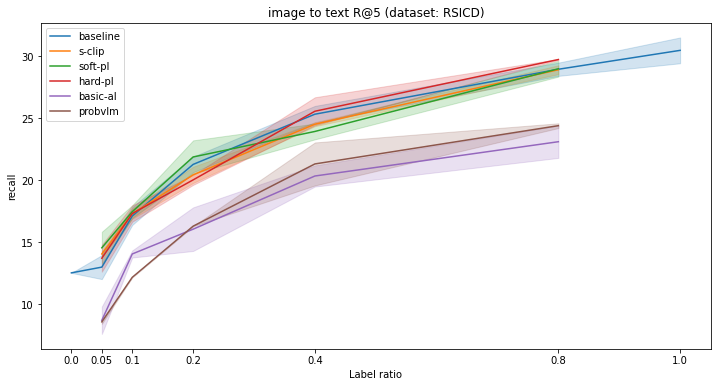

baseline image_to_text_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
9152     UCM   False  image_to_text_R@5  0.00       0.0  0.00005  None      0   
9158     UCM   False  image_to_text_R@5  0.05      25.0  0.00005  None     25   
9246     UCM   False  image_to_text_R@5  0.10      25.0  0.00005  None     25   
9334     UCM   False  image_to_text_R@5  0.20      25.0  0.00005  None     25   
9442     UCM   False  image_to_text_R@5  0.40      25.0  0.00005  None     25   
9550     UCM   False  image_to_text_R@5  0.80      25.0  0.00005  None     25   
9655     UCM   False  image_to_text_R@5  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
9152   base     NaN  64  29.520  0.000000     2  
9158   base     NaN  64  34.954  1.704444     5  
9246   base     NaN  64  39.810  3.220877     5  
9334   base     NaN  64  48.286  2.395074     5  
9442   base     NaN  64  52.000  2.412955     5  
9550   base     NaN  64  55.716  1.784637     5  
9655   base     NaN  64  58.384  1.562380     5

s-clip image_to_text_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
9210     UCM   False  image_to_text_R@5  0.05      25.0  0.00005  ot.image   
9298     UCM   False  image_to_text_R@5  0.10      25.0  0.00005  ot.image   
9386     UCM   False  image_to_text_R@5  0.20      25.0  0.00005  ot.image   
9494     UCM   False  image_to_text_R@5  0.40      25.0  0.00005  ot.image   
9600     UCM   False  image_to_text_R@5  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
9210     25   ours     NaN  128  36.092  2.085454     5  
9298     25   ours     NaN  128  42.478  0.854178     5  
9386     25   ours     NaN  128  50.474  1.064368     5  
9494     25   ours     NaN  128  49.052  2.128737     5  
9600     25   ours     NaN  128  59.050  2.936614     5

soft-pl image_to_text_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
9240     UCM   False  image_to_text_R@5  0.05      30.0  0.00005  soft.text   
9328     UCM   False  image_to_text_R@5  0.10      30.0  0.00005  soft.text   
9416     UCM   False  image_to_text_R@5  0.20      30.0  0.00005  soft.text   
9524     UCM   False  image_to_text_R@5  0.40      30.0  0.00005  soft.text   
9630     UCM   False  image_to_text_R@5  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
9240     30   ours     NaN  64  37.334  1.737910     5  
9328     30   ours     NaN  64  40.286  3.309151     5  
9416     30   ours     NaN  64  47.240  2.743866     5  
9524     30   ours     NaN  64  52.952  3.537438     5  
9630     30   ours     NaN  64  55.428  1.043417     5

hard-pl image_to_text_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
9185     UCM   False  image_to_text_R@5  0.05      25.0  0.00005  hard.text   
9273     UCM   False  image_to_text_R@5  0.10      25.0  0.00005  hard.text   
9361     UCM   False  image_to_text_R@5  0.20      25.0  0.00005  hard.text   
9469     UCM   False  image_to_text_R@5  0.40      25.0  0.00005  hard.text   
9575     UCM   False  image_to_text_R@5  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
9185     25   ours     NaN  64  35.622  4.884902     5  
9273     25   ours     NaN  64  42.760  1.915568     5  
9361     25   ours     NaN  64  47.810  3.423543     5  
9469     25   ours     NaN  64  54.666  3.020576     5  
9575     25   ours     NaN  64  57.052  2.343399     5

basic-al image_to_text_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
9153     UCM   False  image_to_text_R@5  0.05      10.0  0.00005  None     20   
9241     UCM   False  image_to_text_R@5  0.10      10.0  0.00005  None     20   
9329     UCM   False  image_to_text_R@5  0.20      10.0  0.00005  None     20   
9417     UCM   False  image_to_text_R@5  0.40      10.0  0.00005  None     20   
9525     UCM   False  image_to_text_R@5  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
9153   base     2.0  64  33.238  2.943802     5  
9241   base     5.0  64  36.192  4.795667     5  
9329   base    10.0  64  44.762  3.704918     5  
9417   base    20.0  64  49.240  1.040673     5  
9525   base    40.0  64  52.952  0.783243     5

probvlm image_to_text_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
11178     UCM    True  image_to_text_R@5  0.05      10.0  0.00005  None   
11179     UCM    True  image_to_text_R@5  0.10      10.0  0.00005  None   
11180     UCM    True  image_to_text_R@5  0.20      10.0  0.00005  None   
11181     UCM    True  image_to_text_R@5  0.40      10.0  0.00005  None   
11182     UCM    True  image_to_text_R@5  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11178     25   base     2.0  32  29.812  1.493693     5  
11179     25   base     5.0  32  34.760  0.000000     5  
11180     25   base    10.0  32  43.330  0.000000     5  
11181     25   base    20.0  32  49.140  4.208943     5  
11182     25   base    40.0  32  44.285  0.671751     2

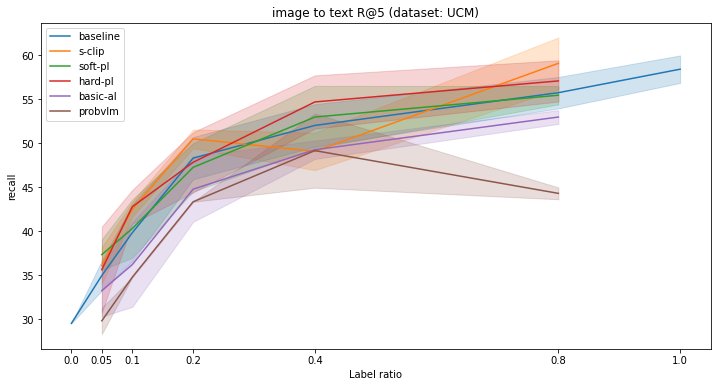

baseline image_to_text_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
6098  Sydney   False  image_to_text_R@5  0.00       0.0  0.00005  None      0   
6104  Sydney   False  image_to_text_R@5  0.05      25.0  0.00005  None     25   
6192  Sydney   False  image_to_text_R@5  0.10      25.0  0.00005  None     25   
6280  Sydney   False  image_to_text_R@5  0.20      25.0  0.00005  None     25   
6388  Sydney   False  image_to_text_R@5  0.40      25.0  0.00005  None     25   
6496  Sydney   False  image_to_text_R@5  0.80      25.0  0.00005  None     25   
6601  Sydney   False  image_to_text_R@5  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
6098   base     NaN  64   7.040  0.000000     2  
6104   base     NaN  64   9.498  1.629193     5  
6192   base     NaN  64  10.944  1.842099     5  
6280   base     NaN  64  15.454  1.396954     5  
6388   base     NaN  64  25.954  1.208338     5  
6496   base     NaN  64  39.274  1.375384     5  
6601   base     NaN  64  38.270  1.289981     5

s-clip image_to_text_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
6156  Sydney   False  image_to_text_R@5  0.05      25.0  0.00005  ot.image   
6244  Sydney   False  image_to_text_R@5  0.10      25.0  0.00005  ot.image   
6332  Sydney   False  image_to_text_R@5  0.20      25.0  0.00005  ot.image   
6440  Sydney   False  image_to_text_R@5  0.40      25.0  0.00005  ot.image   
6546  Sydney   False  image_to_text_R@5  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
6156     25   ours     NaN  128   9.940  0.862583     5  
6244     25   ours     NaN  128  11.748  0.720014     5  
6332     25   ours     NaN  128  13.120  0.089443     5  
6440     25   ours     NaN  128  19.152  0.093915     5  
6546     25   ours     NaN  128  31.268  1.657564     5

soft-pl image_to_text_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
6186  Sydney   False  image_to_text_R@5  0.05      30.0  0.00005  soft.text   
6274  Sydney   False  image_to_text_R@5  0.10      30.0  0.00005  soft.text   
6362  Sydney   False  image_to_text_R@5  0.20      30.0  0.00005  soft.text   
6470  Sydney   False  image_to_text_R@5  0.40      30.0  0.00005  soft.text   
6576  Sydney   False  image_to_text_R@5  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
6186     30   ours     NaN  64   9.294  0.846540     5  
6274     30   ours     NaN  64  10.786  1.423808     5  
6362     30   ours     NaN  64  14.526  0.929774     5  
6470     30   ours     NaN  64  19.920  1.479223     5  
6576     30   ours     NaN  64  27.928  1.676595     5

hard-pl image_to_text_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
6131  Sydney   False  image_to_text_R@5  0.05      25.0  0.00005  hard.text   
6219  Sydney   False  image_to_text_R@5  0.10      25.0  0.00005  hard.text   
6307  Sydney   False  image_to_text_R@5  0.20      25.0  0.00005  hard.text   
6415  Sydney   False  image_to_text_R@5  0.40      25.0  0.00005  hard.text   
6521  Sydney   False  image_to_text_R@5  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
6131     25   ours     NaN  64   9.900  0.822830     5  
6219     25   ours     NaN  64  11.548  1.408020     5  
6307     25   ours     NaN  64  12.234  1.341801     5  
6415     25   ours     NaN  64  18.390  1.413895     5  
6521     25   ours     NaN  64  24.706  1.712828     5

basic-al image_to_text_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
6099  Sydney   False  image_to_text_R@5  0.05      10.0  0.00005  None     20   
6187  Sydney   False  image_to_text_R@5  0.10      10.0  0.00005  None     20   
6275  Sydney   False  image_to_text_R@5  0.20      10.0  0.00005  None     20   
6363  Sydney   False  image_to_text_R@5  0.40      10.0  0.00005  None     20   
6471  Sydney   False  image_to_text_R@5  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
6099   base     2.0  64   6.638  1.357229     5  
6187   base     5.0  64  10.540  0.268328     5  
6275   base    10.0  64  14.370  4.299622     5  
6363   base    20.0  64  21.528  2.755044     5  
6471   base    40.0  64  31.872  0.996855     5

probvlm image_to_text_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
8124  Sydney    True  image_to_text_R@5  0.05      10.0  0.00005  None     25   
8125  Sydney    True  image_to_text_R@5  0.10      10.0  0.00005  None     25   
8126  Sydney    True  image_to_text_R@5  0.20      10.0  0.00005  None     25   
8127  Sydney    True  image_to_text_R@5  0.40      10.0  0.00005  None     25   
8128  Sydney    True  image_to_text_R@5  0.80      10.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
8124   base     2.0  32   8.772  0.720014     5  
8125   base     5.0  32  11.070  0.000000     5  
8126   base    10.0  32  10.870  0.000000     5  
8127   base    20.0  32  15.088  0.791846     5  
8128   base    40.0  32  17.705  1.138442     2

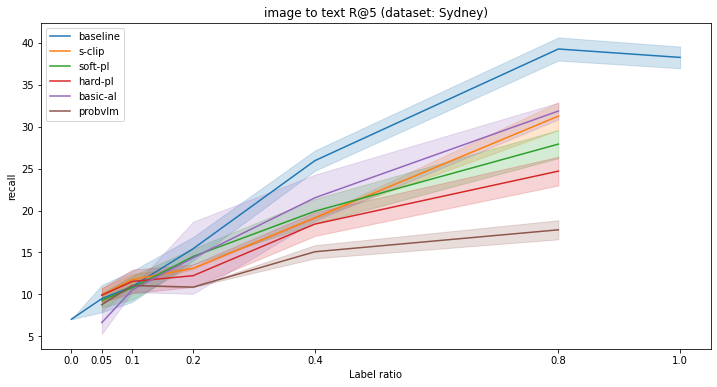

baseline text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
3538   RSICD   False  text_to_image_R@5  0.00       0.0  0.00005  None      0   
3544   RSICD   False  text_to_image_R@5  0.05      25.0  0.00005  None     25   
3632   RSICD   False  text_to_image_R@5  0.10      25.0  0.00005  None     25   
3720   RSICD   False  text_to_image_R@5  0.20      25.0  0.00005  None     25   
3828   RSICD   False  text_to_image_R@5  0.40      25.0  0.00005  None     25   
3936   RSICD   False  text_to_image_R@5  0.80      25.0  0.00005  None     25   
4041   RSICD   False  text_to_image_R@5  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
3538   base     NaN  64  14.270  0.000000     2  
3544   base     NaN  64  13.122  0.420678     5  
3632   base     NaN  64  16.690  0.939920     5  
3720   base     NaN  64  20.806  1.018052     5  
3828   base     NaN  64  24.904  0.638968     5  
3936   base     NaN  64  29.532  0.979525     5  
4041   base     NaN  64  31.070  1.026913     5

s-clip text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
3596   RSICD   False  text_to_image_R@5  0.05      25.0  0.00005  ot.image   
3684   RSICD   False  text_to_image_R@5  0.10      25.0  0.00005  ot.image   
3772   RSICD   False  text_to_image_R@5  0.20      25.0  0.00005  ot.image   
3880   RSICD   False  text_to_image_R@5  0.40      25.0  0.00005  ot.image   
3986   RSICD   False  text_to_image_R@5  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
3596     25   ours     NaN  128  13.924  0.474847     5  
3684     25   ours     NaN  128  17.196  0.818401     5  
3772     25   ours     NaN  128  19.978  0.286217     5  
3880     25   ours     NaN  128  23.462  0.898899     5  
3986     25   ours     NaN  128  28.968  0.733430     5

soft-pl text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
3626   RSICD   False  text_to_image_R@5  0.05      30.0  0.00005  soft.text   
3714   RSICD   False  text_to_image_R@5  0.10      30.0  0.00005  soft.text   
3802   RSICD   False  text_to_image_R@5  0.20      30.0  0.00005  soft.text   
3910   RSICD   False  text_to_image_R@5  0.40      30.0  0.00005  soft.text   
4016   RSICD   False  text_to_image_R@5  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
3626     30   ours     NaN  64  14.638  0.614549     5  
3714     30   ours     NaN  64  18.152  0.697653     5  
3802     30   ours     NaN  64  22.234  1.206764     5  
3910     30   ours     NaN  64  25.712  0.497112     5  
4016     30   ours     NaN  64  30.062  1.053551     5

hard-pl text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
3571   RSICD   False  text_to_image_R@5  0.05      25.0  0.00005  hard.text   
3659   RSICD   False  text_to_image_R@5  0.10      25.0  0.00005  hard.text   
3747   RSICD   False  text_to_image_R@5  0.20      25.0  0.00005  hard.text   
3855   RSICD   False  text_to_image_R@5  0.40      25.0  0.00005  hard.text   
3961   RSICD   False  text_to_image_R@5  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
3571     25   ours     NaN  64  13.630  0.606795     5  
3659     25   ours     NaN  64  17.988  1.053812     5  
3747     25   ours     NaN  64  20.258  0.612021     5  
3855     25   ours     NaN  64  25.616  0.849723     5  
3961     25   ours     NaN  64  30.248  0.532184     5

basic-al text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
3539   RSICD   False  text_to_image_R@5  0.05      10.0  0.00005  None     20   
3627   RSICD   False  text_to_image_R@5  0.10      10.0  0.00005  None     20   
3715   RSICD   False  text_to_image_R@5  0.20      10.0  0.00005  None     20   
3803   RSICD   False  text_to_image_R@5  0.40      10.0  0.00005  None     20   
3911   RSICD   False  text_to_image_R@5  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
3539   base     2.0  64   8.324  1.836608     5  
3627   base     5.0  64  12.422  0.075299     5  
3715   base    10.0  64  15.830  1.833548     5  
3803   base    20.0  64  20.806  1.456942     5  
3911   base    40.0  64  24.210  0.301247     5

probvlm text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
4067   RSICD    True  text_to_image_R@5  0.05      10.0  0.00005  None     25   
4068   RSICD    True  text_to_image_R@5  0.10      10.0  0.00005  None     25   
4069   RSICD    True  text_to_image_R@5  0.20      10.0  0.00005  None     25   
4070   RSICD    True  text_to_image_R@5  0.40      10.0  0.00005  None     25   
4071   RSICD    True  text_to_image_R@5  0.80      10.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
4067   base     2.0  32   7.760  0.245967     5  
4068   base     5.0  32  12.630  0.000000     5  
4069   base    10.0  32  17.020  0.000000     5  
4070   base    20.0  32  21.082  0.339588     5  
4071   base    40.0  32  24.335  1.294005     2

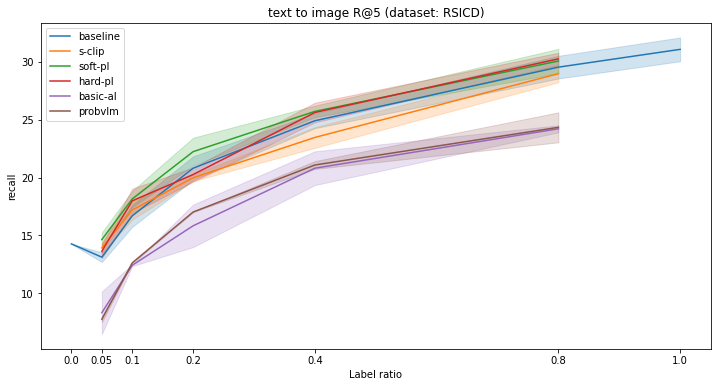

baseline text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
10664     UCM   False  text_to_image_R@5  0.00       0.0  0.00005  None   
10670     UCM   False  text_to_image_R@5  0.05      25.0  0.00005  None   
10758     UCM   False  text_to_image_R@5  0.10      25.0  0.00005  None   
10846     UCM   False  text_to_image_R@5  0.20      25.0  0.00005  None   
10954     UCM   False  text_to_image_R@5  0.40      25.0  0.00005  None   
11062     UCM   False  text_to_image_R@5  0.80      25.0  0.00005  None   
11167     UCM   False  text_to_image_R@5  1.00      25.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10664      0   base     NaN  64  31.430  0.000000     2  
10670     25   base     NaN  64  35.142  3.341118     5  
10758     25   base     NaN  64  38.096  1.814657     5  
10846     25   base     NaN  64  48.666  1.033697     5  
10954     25   base     NaN  64  50.666  1.735578     5  
11062     25   base     NaN  64  55.334  1.824179     5  
11167     25   base     NaN  64  59.714  2.558062     5

s-clip text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                              
10722     UCM   False  text_to_image_R@5  0.05      25.0  0.00005  ot.image   
10810     UCM   False  text_to_image_R@5  0.10      25.0  0.00005  ot.image   
10898     UCM   False  text_to_image_R@5  0.20      25.0  0.00005  ot.image   
11006     UCM   False  text_to_image_R@5  0.40      25.0  0.00005  ot.image   
11112     UCM   False  text_to_image_R@5  0.80      25.0  0.00005  ot.image   

      epochs method AL.iter   bs   value                  
                                    mean       std count  
10722     25   ours     NaN  128  36.096  1.829393     5  
10810     25   ours     NaN  128  43.140  0.424853     5  
10898     25   ours     NaN  128  52.950  0.849706     5  
11006     25   ours     NaN  128  51.900  0.000000     5  
11112     25   ours     NaN  128  58.854  1.489221     5

soft-pl text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                               
10752     UCM   False  text_to_image_R@5  0.05      30.0  0.00005  soft.text   
10840     UCM   False  text_to_image_R@5  0.10      30.0  0.00005  soft.text   
10928     UCM   False  text_to_image_R@5  0.20      30.0  0.00005  soft.text   
11036     UCM   False  text_to_image_R@5  0.40      30.0  0.00005  soft.text   
11142     UCM   False  text_to_image_R@5  0.80      30.0  0.00005  soft.text   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10752     30   ours     NaN  64  38.192  3.292107     5  
10840     30   ours     NaN  64  42.476  1.362289     5  
10928     30   ours     NaN  64  46.474  0.926974     5  
11036     30   ours     NaN  64  52.188  1.192841     5  
11142     30   ours     NaN  64  57.618  1.431667     5

hard-pl text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                               
10697     UCM   False  text_to_image_R@5  0.05      25.0  0.00005  hard.text   
10785     UCM   False  text_to_image_R@5  0.10      25.0  0.00005  hard.text   
10873     UCM   False  text_to_image_R@5  0.20      25.0  0.00005  hard.text   
10981     UCM   False  text_to_image_R@5  0.40      25.0  0.00005  hard.text   
11087     UCM   False  text_to_image_R@5  0.80      25.0  0.00005  hard.text   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10697     25   ours     NaN  64  35.430  3.755210     5  
10785     25   ours     NaN  64  43.906  3.390403     5  
10873     25   ours     NaN  64  48.476  3.202246     5  
10981     25   ours     NaN  64  53.998  3.096784     5  
11087     25   ours     NaN  64  59.808  2.553590     5

basic-al text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
10665     UCM   False  text_to_image_R@5  0.05      10.0  0.00005  None   
10753     UCM   False  text_to_image_R@5  0.10      10.0  0.00005  None   
10841     UCM   False  text_to_image_R@5  0.20      10.0  0.00005  None   
10929     UCM   False  text_to_image_R@5  0.40      10.0  0.00005  None   
11037     UCM   False  text_to_image_R@5  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10665     20   base     2.0  64  33.428  1.915690     5  
10753     20   base     5.0  64  39.046  1.064368     5  
10841     20   base    10.0  64  42.856  1.344388     5  
10929     20   base    20.0  64  48.666  3.127496     5  
11037     20   base    40.0  64  52.858  1.303580     5

probvlm text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
11193     UCM    True  text_to_image_R@5  0.05      10.0  0.00005  None   
11194     UCM    True  text_to_image_R@5  0.10      10.0  0.00005  None   
11195     UCM    True  text_to_image_R@5  0.20      10.0  0.00005  None   
11196     UCM    True  text_to_image_R@5  0.40      10.0  0.00005  None   
11197     UCM    True  text_to_image_R@5  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11193     25   base     2.0  32  29.242  2.768252     5  
11194     25   base     5.0  32  36.190  0.000000     5  
11195     25   base    10.0  32  42.380  0.000000     5  
11196     25   base    20.0  32  45.528  2.768252     5  
11197     25   base    40.0  32  45.475  0.332340     2

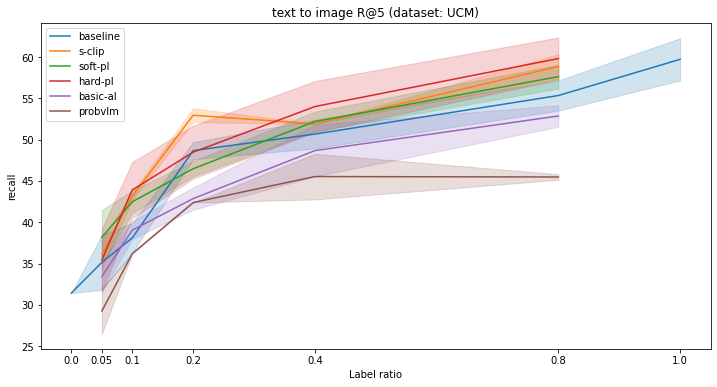

baseline text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
7610  Sydney   False  text_to_image_R@5  0.00       0.0  0.00005  None      0   
7616  Sydney   False  text_to_image_R@5  0.05      25.0  0.00005  None     25   
7704  Sydney   False  text_to_image_R@5  0.10      25.0  0.00005  None     25   
7792  Sydney   False  text_to_image_R@5  0.20      25.0  0.00005  None     25   
7900  Sydney   False  text_to_image_R@5  0.40      25.0  0.00005  None     25   
8008  Sydney   False  text_to_image_R@5  0.80      25.0  0.00005  None     25   
8113  Sydney   False  text_to_image_R@5  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
7610   base     NaN  64  10.660  0.000000     2  
7616   base     NaN  64  10.746  0.677370     5  
7704   base     NaN  64  14.406  1.293940     5  
7792   base     NaN  64  18.350  2.141775     5  
7900   base     NaN  64  27.044  1.087764     5  
8008   base     NaN  64  36.578  1.041091     5  
8113   base     NaN  64  37.666  0.438668     5

s-clip text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
7668  Sydney   False  text_to_image_R@5  0.05      25.0  0.00005  ot.image   
7756  Sydney   False  text_to_image_R@5  0.10      25.0  0.00005  ot.image   
7844  Sydney   False  text_to_image_R@5  0.20      25.0  0.00005  ot.image   
7952  Sydney   False  text_to_image_R@5  0.40      25.0  0.00005  ot.image   
8058  Sydney   False  text_to_image_R@5  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
7668     25   ours     NaN  128   9.742  1.077785     5  
7756     25   ours     NaN  128  14.568  0.720014     5  
7844     25   ours     NaN  128  17.140  0.357771     5  
7952     25   ours     NaN  128  22.014  1.529470     5  
8058     25   ours     NaN  128  31.710  0.178885     5

soft-pl text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
7698  Sydney   False  text_to_image_R@5  0.05      30.0  0.00005  soft.text   
7786  Sydney   False  text_to_image_R@5  0.10      30.0  0.00005  soft.text   
7874  Sydney   False  text_to_image_R@5  0.20      30.0  0.00005  soft.text   
7982  Sydney   False  text_to_image_R@5  0.40      30.0  0.00005  soft.text   
8088  Sydney   False  text_to_image_R@5  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
7698     30   ours     NaN  64  11.146  2.197494     5  
7786     30   ours     NaN  64  12.714  1.453850     5  
7874     30   ours     NaN  64  17.382  0.719458     5  
7982     30   ours     NaN  64  20.806  1.218536     5  
8088     30   ours     NaN  64  27.848  0.442063     5

hard-pl text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
7643  Sydney   False  text_to_image_R@5  0.05      25.0  0.00005  hard.text   
7731  Sydney   False  text_to_image_R@5  0.10      25.0  0.00005  hard.text   
7819  Sydney   False  text_to_image_R@5  0.20      25.0  0.00005  hard.text   
7927  Sydney   False  text_to_image_R@5  0.40      25.0  0.00005  hard.text   
8033  Sydney   False  text_to_image_R@5  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
7643     25   ours     NaN  64   9.656  0.752350     5  
7731     25   ours     NaN  64  12.876  0.493994     5  
7819     25   ours     NaN  64  16.016  0.848664     5  
7927     25   ours     NaN  64  21.328  1.865508     5  
8033     25   ours     NaN  64  26.200  0.089443     5

basic-al text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
7611  Sydney   False  text_to_image_R@5  0.05      10.0  0.00005  None     20   
7699  Sydney   False  text_to_image_R@5  0.10      10.0  0.00005  None     20   
7787  Sydney   False  text_to_image_R@5  0.20      10.0  0.00005  None     20   
7875  Sydney   False  text_to_image_R@5  0.40      10.0  0.00005  None     20   
7983  Sydney   False  text_to_image_R@5  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
7611   base     2.0  64   8.250  0.648074     5  
7699   base     5.0  64  10.464  1.797799     5  
7787   base    10.0  64  16.096  4.025001     5  
7875   base    20.0  64  21.324  3.855967     5  
7983   base    40.0  64  33.122  1.763667     5

probvlm text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
8139  Sydney    True  text_to_image_R@5  0.05      10.0  0.00005  None     25   
8140  Sydney    True  text_to_image_R@5  0.10      10.0  0.00005  None     25   
8141  Sydney    True  text_to_image_R@5  0.20      10.0  0.00005  None     25   
8142  Sydney    True  text_to_image_R@5  0.40      10.0  0.00005  None     25   
8143  Sydney    True  text_to_image_R@5  0.80      10.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
8139   base     2.0  32   8.810  0.089443     5  
8140   base     5.0  32  13.480  0.000000     5  
8141   base    10.0  32  12.680  0.000000     5  
8142   base    20.0  32  15.978  0.718624     5  
8143   base    40.0  32  18.815  1.845549     2

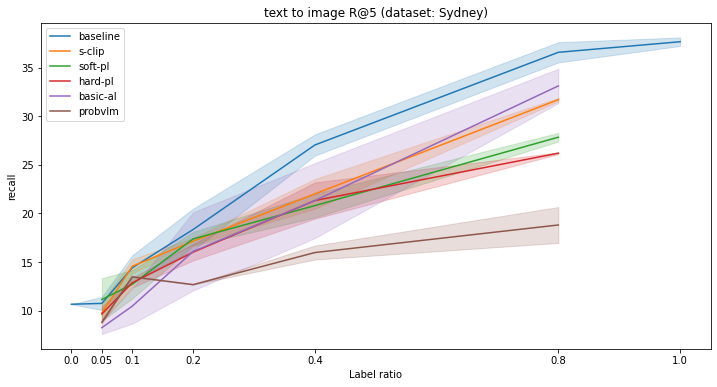

In [19]:
metrics = ['image_to_text_R@5', 'text_to_image_R@5']
datasets = ['RSICD', 'UCM', 'Sydney']
for metric in metrics:
    for dataset in datasets:
        plot_model_comparison(results_dict, metric, dataset)

RSICD-CLS zeroshot-val-top1
baseline zeroshot-val-top1 RSICD-CLS


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                            
4072  RSICD-CLS   False  zeroshot-val-top1  0.00       0.0  0.00005  None   
4078  RSICD-CLS   False  zeroshot-val-top1  0.05      25.0  0.00005  None   
4166  RSICD-CLS   False  zeroshot-val-top1  0.10      25.0  0.00005  None   
4254  RSICD-CLS   False  zeroshot-val-top1  0.20      25.0  0.00005  None   
4362  RSICD-CLS   False  zeroshot-val-top1  0.40      25.0  0.00005  None   
4470  RSICD-CLS   False  zeroshot-val-top1  0.80      25.0  0.00005  None   
4575  RSICD-CLS   False  zeroshot-val-top1  1.00      25.0  0.00005  None   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
4072      0   base     NaN  64  53.710  0.000000     3  
4078     25   base     NaN  64  56.652  1.917008     5  
4166     25   base     NaN  64  63.916  1.673090     5  
4254     25   base     NaN  64  72.700  1.399071     5  
4362     25   base     NaN  64  83.220  1.070047     5  
4470     25   base     NaN  64  84.592  2.209835     5  
4575     25   base     NaN  64  85.142  1.542359     5

s-clip zeroshot-val-top1 RSICD-CLS


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                                
4130  RSICD-CLS   False  zeroshot-val-top1  0.05      25.0  0.00005  ot.image   
4218  RSICD-CLS   False  zeroshot-val-top1  0.10      25.0  0.00005  ot.image   
4306  RSICD-CLS   False  zeroshot-val-top1  0.20      25.0  0.00005  ot.image   
4414  RSICD-CLS   False  zeroshot-val-top1  0.40      25.0  0.00005  ot.image   
4520  RSICD-CLS   False  zeroshot-val-top1  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
4130     25   ours     NaN  128  55.884  1.488247     5  
4218     25   ours     NaN  128  64.828  2.128737     5  
4306     25   ours     NaN  128  77.950  1.229837     5  
4414     25   ours     NaN  128  85.580  0.939149     5  
4520     25   ours     NaN  128  86.732  1.024119     5

soft-pl zeroshot-val-top1 RSICD-CLS


dataset ProbVLM             metric ratio AL.epochs       lr  \
                                                                      
4160  RSICD-CLS   False  zeroshot-val-top1  0.05      30.0  0.00005   
4248  RSICD-CLS   False  zeroshot-val-top1  0.10      30.0  0.00005   
4336  RSICD-CLS   False  zeroshot-val-top1  0.20      30.0  0.00005   
4444  RSICD-CLS   False  zeroshot-val-top1  0.40      30.0  0.00005   
4550  RSICD-CLS   False  zeroshot-val-top1  0.80      30.0  0.00005   

             PL epochs method AL.iter  bs   value                  
                                             mean       std count  
4160  soft.text     30   ours     NaN  64  57.108  1.777645     5  
4248  soft.text     30   ours     NaN  64  63.640  0.868188     5  
4336  soft.text     30   ours     NaN  64  77.016  1.222448     5  
4444  soft.text     30   ours     NaN  64  83.168  2.388874     5  
4550  soft.text     30   ours     NaN  64  88.748  0.948061     5

hard-pl zeroshot-val-top1 RSICD-CLS


dataset ProbVLM             metric ratio AL.epochs       lr  \
                                                                      
4105  RSICD-CLS   False  zeroshot-val-top1  0.05      25.0  0.00005   
4193  RSICD-CLS   False  zeroshot-val-top1  0.10      25.0  0.00005   
4281  RSICD-CLS   False  zeroshot-val-top1  0.20      25.0  0.00005   
4389  RSICD-CLS   False  zeroshot-val-top1  0.40      25.0  0.00005   
4495  RSICD-CLS   False  zeroshot-val-top1  0.80      25.0  0.00005   

             PL epochs method AL.iter  bs   value                  
                                             mean       std count  
4105  hard.text     25   ours     NaN  64  59.012  1.691204     5  
4193  hard.text     25   ours     NaN  64  65.214  2.675253     5  
4281  hard.text     25   ours     NaN  64  75.314  0.452526     5  
4389  hard.text     25   ours     NaN  64  82.086  2.044170     5  
4495  hard.text     25   ours     NaN  64  84.888  0.979398     5

basic-al zeroshot-val-top1 RSICD-CLS


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                            
4073  RSICD-CLS   False  zeroshot-val-top1  0.05      10.0  0.00005  None   
4161  RSICD-CLS   False  zeroshot-val-top1  0.10      10.0  0.00005  None   
4249  RSICD-CLS   False  zeroshot-val-top1  0.20      10.0  0.00005  None   
4337  RSICD-CLS   False  zeroshot-val-top1  0.40      10.0  0.00005  None   
4445  RSICD-CLS   False  zeroshot-val-top1  0.80      10.0  0.00005  None   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
4073     20   base     2.0  64  42.434  2.685280     5  
4161     20   base     5.0  64  57.002  3.735555     5  
4249     20   base    10.0  64  62.452  7.301234     5  
4337     20   base    20.0  64  71.418  3.708082     5  
4445     20   base    40.0  64  78.776  1.500760     5

probvlm zeroshot-val-top1 RSICD-CLS


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                            
4576  RSICD-CLS    True  zeroshot-val-top1  0.05      10.0  0.00005  None   
4577  RSICD-CLS    True  zeroshot-val-top1  0.10      10.0  0.00005  None   
4578  RSICD-CLS    True  zeroshot-val-top1  0.20      10.0  0.00005  None   
4579  RSICD-CLS    True  zeroshot-val-top1  0.40      10.0  0.00005  None   
4580  RSICD-CLS    True  zeroshot-val-top1  0.80      10.0  0.00005  None   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
4576     25   base     2.0  32  38.460  0.290689     5  
4577     25   base     5.0  32  53.610  0.000000     5  
4578     25   base    10.0  32  61.480  0.000000     5  
4579     25   base    20.0  32  73.832  5.242053     5  
4580     25   base    40.0  32  83.715  0.516188     2

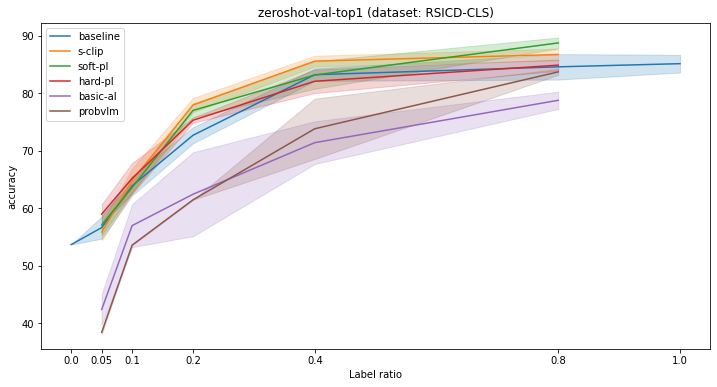

UCM-CLS zeroshot-val-top1
baseline zeroshot-val-top1 UCM-CLS


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                           
11198  UCM-CLS   False  zeroshot-val-top1  0.00       0.0  0.00005  None   
11204  UCM-CLS   False  zeroshot-val-top1  0.05      25.0  0.00005  None   
11292  UCM-CLS   False  zeroshot-val-top1  0.10      25.0  0.00005  None   
11380  UCM-CLS   False  zeroshot-val-top1  0.20      25.0  0.00005  None   
11488  UCM-CLS   False  zeroshot-val-top1  0.40      25.0  0.00005  None   
11596  UCM-CLS   False  zeroshot-val-top1  0.80      25.0  0.00005  None   
11701  UCM-CLS   False  zeroshot-val-top1  1.00      25.0  0.00005  None   

      epochs method AL.iter  bs   value                      
                                   mean           std count  
11198      0   base     NaN  64  49.050  8.702336e-15     3  
11204     25   base     NaN  64  53.332  2.104904e+00     5  
11292     25   base     NaN  64  57.712  1.974062e+00     5  
11380     25   base     NaN  64  68.476  1.361591e+00     5  
11488     25   base     NaN  64  71.238  2.924691e+00     5  
11596     25   base     NaN  64  76.284  1.827438e+00     5  
11701     25   base     NaN  64  68.666  3.150775e+00     5

s-clip zeroshot-val-top1 UCM-CLS


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                               
11256  UCM-CLS   False  zeroshot-val-top1  0.05      25.0  0.00005  ot.image   
11344  UCM-CLS   False  zeroshot-val-top1  0.10      25.0  0.00005  ot.image   
11432  UCM-CLS   False  zeroshot-val-top1  0.20      25.0  0.00005  ot.image   
11540  UCM-CLS   False  zeroshot-val-top1  0.40      25.0  0.00005  ot.image   
11646  UCM-CLS   False  zeroshot-val-top1  0.80      25.0  0.00005  ot.image   

      epochs method AL.iter   bs   value                  
                                    mean       std count  
11256     25   ours     NaN  128  57.904  1.046150     5  
11344     25   ours     NaN  128  63.618  1.192841     5  
11432     25   ours     NaN  128  70.384  0.214663     5  
11540     25   ours     NaN  128  68.760  0.424853     5  
11646     25   ours     NaN  128  73.426  0.214663     5

soft-pl zeroshot-val-top1 UCM-CLS


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                                
11286  UCM-CLS   False  zeroshot-val-top1  0.05      30.0  0.00005  soft.text   
11374  UCM-CLS   False  zeroshot-val-top1  0.10      30.0  0.00005  soft.text   
11462  UCM-CLS   False  zeroshot-val-top1  0.20      30.0  0.00005  soft.text   
11570  UCM-CLS   False  zeroshot-val-top1  0.40      30.0  0.00005  soft.text   
11676  UCM-CLS   False  zeroshot-val-top1  0.80      30.0  0.00005  soft.text   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11286     30   ours     NaN  64  53.812  2.104904     5  
11374     30   ours     NaN  64  62.762  3.523283     5  
11462     30   ours     NaN  64  71.716  0.639515     5  
11570     30   ours     NaN  64  73.142  0.986671     5  
11676     30   ours     NaN  64  73.618  2.170500     5

hard-pl zeroshot-val-top1 UCM-CLS


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                                
11231  UCM-CLS   False  zeroshot-val-top1  0.05      25.0  0.00005  hard.text   
11319  UCM-CLS   False  zeroshot-val-top1  0.10      25.0  0.00005  hard.text   
11407  UCM-CLS   False  zeroshot-val-top1  0.20      25.0  0.00005  hard.text   
11515  UCM-CLS   False  zeroshot-val-top1  0.40      25.0  0.00005  hard.text   
11621  UCM-CLS   False  zeroshot-val-top1  0.80      25.0  0.00005  hard.text   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11231     25   ours     NaN  64  51.618  5.267326     5  
11319     25   ours     NaN  64  62.948  2.702086     5  
11407     25   ours     NaN  64  67.906  2.513102     5  
11515     25   ours     NaN  64  73.904  3.707024     5  
11621     25   ours     NaN  64  69.716  1.489221     5

basic-al zeroshot-val-top1 UCM-CLS


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                           
11199  UCM-CLS   False  zeroshot-val-top1  0.05      10.0  0.00005  None   
11287  UCM-CLS   False  zeroshot-val-top1  0.10      10.0  0.00005  None   
11375  UCM-CLS   False  zeroshot-val-top1  0.20      10.0  0.00005  None   
11463  UCM-CLS   False  zeroshot-val-top1  0.40      10.0  0.00005  None   
11571  UCM-CLS   False  zeroshot-val-top1  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11199     20   base     2.0  64  54.952  3.381016     5  
11287     20   base     5.0  64  55.906  4.686798     5  
11375     20   base    10.0  64  63.806  1.782633     5  
11463     20   base    20.0  64  65.998  3.653309     5  
11571     20   base    40.0  64  72.188  3.653309     5

probvlm zeroshot-val-top1 UCM-CLS


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                           
11702  UCM-CLS    True  zeroshot-val-top1  0.05      10.0  0.00005  None   
11703  UCM-CLS    True  zeroshot-val-top1  0.10      10.0  0.00005  None   
11704  UCM-CLS    True  zeroshot-val-top1  0.20      10.0  0.00005  None   
11705  UCM-CLS    True  zeroshot-val-top1  0.40      10.0  0.00005  None   
11706  UCM-CLS    True  zeroshot-val-top1  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                      
                                   mean           std count  
11702     25   base     2.0  32  43.332  3.193105e+00     5  
11703     25   base     5.0  32  52.860  0.000000e+00     5  
11704     25   base    10.0  32  58.570  7.944109e-15     5  
11705     25   base    20.0  32  67.240  6.203128e+00     5  
11706     25   base    40.0  32  68.095  4.716402e+00     2

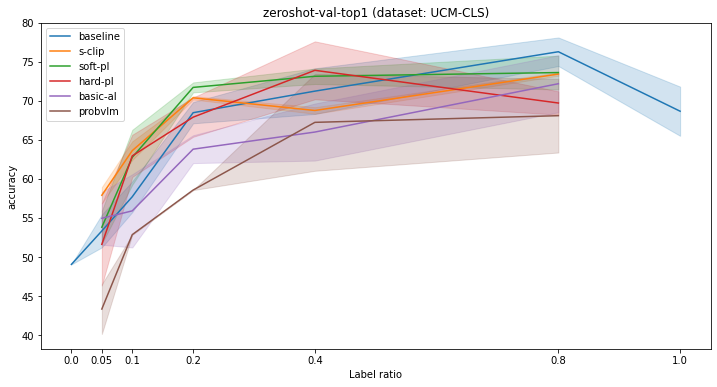

WHU-RS19 zeroshot-val-top1
baseline zeroshot-val-top1 WHU-RS19


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                            
11707  WHU-RS19   False  zeroshot-val-top1  0.00       0.0  0.00005  None   
11713  WHU-RS19   False  zeroshot-val-top1  0.05      25.0  0.00005  None   
11801  WHU-RS19   False  zeroshot-val-top1  0.10      25.0  0.00005  None   
11889  WHU-RS19   False  zeroshot-val-top1  0.20      25.0  0.00005  None   
11997  WHU-RS19   False  zeroshot-val-top1  0.40      25.0  0.00005  None   
12105  WHU-RS19   False  zeroshot-val-top1  0.80      25.0  0.00005  None   
12210  WHU-RS19   False  zeroshot-val-top1  1.00      25.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11707      0   base     NaN  64  68.560  0.000000     3  
11713     25   base     NaN  64  72.816  2.298027     5  
11801     25   base     NaN  64  81.810  1.640290     5  
11889     25   base     NaN  64  86.944  2.460961     5  
11997     25   base     NaN  64  93.252  0.540759     5  
12105     25   base     NaN  64  94.926  0.692120     5  
12210     25   base     NaN  64  93.032  0.500520     5

s-clip zeroshot-val-top1 WHU-RS19


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                                
11765  WHU-RS19   False  zeroshot-val-top1  0.05      25.0  0.00005  ot.image   
11853  WHU-RS19   False  zeroshot-val-top1  0.10      25.0  0.00005  ot.image   
11941  WHU-RS19   False  zeroshot-val-top1  0.20      25.0  0.00005  ot.image   
12049  WHU-RS19   False  zeroshot-val-top1  0.40      25.0  0.00005  ot.image   
12155  WHU-RS19   False  zeroshot-val-top1  0.80      25.0  0.00005  ot.image   

      epochs method AL.iter   bs   value                  
                                    mean       std count  
11765     25   ours     NaN  128  76.776  1.231109     5  
11853     25   ours     NaN  128  84.932  0.979398     5  
11941     25   ours     NaN  128  87.784  2.714587     5  
12049     25   ours     NaN  128  95.780  0.134164     5  
12155     25   ours     NaN  128  96.678  0.353299     5

soft-pl zeroshot-val-top1 WHU-RS19


dataset ProbVLM             metric ratio AL.epochs       lr  \
                                                                      
11795  WHU-RS19   False  zeroshot-val-top1  0.05      30.0  0.00005   
11883  WHU-RS19   False  zeroshot-val-top1  0.10      30.0  0.00005   
11971  WHU-RS19   False  zeroshot-val-top1  0.20      30.0  0.00005   
12079  WHU-RS19   False  zeroshot-val-top1  0.40      30.0  0.00005   
12185  WHU-RS19   False  zeroshot-val-top1  0.80      30.0  0.00005   

              PL epochs method AL.iter  bs   value                  
                                              mean       std count  
11795  soft.text     30   ours     NaN  64  77.570  1.490822     5  
11883  soft.text     30   ours     NaN  64  83.282  3.577467     5  
11971  soft.text     30   ours     NaN  64  91.882  1.660548     5  
12079  soft.text     30   ours     NaN  64  95.680  0.313050     5  
12185  soft.text     30   ours     NaN  64  96.734  0.760809     5

hard-pl zeroshot-val-top1 WHU-RS19


dataset ProbVLM             metric ratio AL.epochs       lr  \
                                                                      
11740  WHU-RS19   False  zeroshot-val-top1  0.05      25.0  0.00005   
11828  WHU-RS19   False  zeroshot-val-top1  0.10      25.0  0.00005   
11916  WHU-RS19   False  zeroshot-val-top1  0.20      25.0  0.00005   
12024  WHU-RS19   False  zeroshot-val-top1  0.40      25.0  0.00005   
12130  WHU-RS19   False  zeroshot-val-top1  0.80      25.0  0.00005   

              PL epochs method AL.iter  bs   value                  
                                              mean       std count  
11740  hard.text     25   ours     NaN  64  76.616  3.076244     5  
11828  hard.text     25   ours     NaN  64  84.160  1.241813     5  
11916  hard.text     25   ours     NaN  64  91.182  1.490107     5  
12024  hard.text     25   ours     NaN  64  93.534  0.952119     5  
12130  hard.text     25   ours     NaN  64  97.134  1.287975     5

basic-al zeroshot-val-top1 WHU-RS19


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                            
11708  WHU-RS19   False  zeroshot-val-top1  0.05      10.0  0.00005  None   
11796  WHU-RS19   False  zeroshot-val-top1  0.10      10.0  0.00005  None   
11884  WHU-RS19   False  zeroshot-val-top1  0.20      10.0  0.00005  None   
11972  WHU-RS19   False  zeroshot-val-top1  0.40      10.0  0.00005  None   
12080  WHU-RS19   False  zeroshot-val-top1  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11708     20   base     2.0  64  57.352  4.002408     5  
11796     20   base     5.0  64  70.686  2.133209     5  
11884     20   base    10.0  64  79.364  3.575735     5  
11972     20   base    20.0  64  84.456  0.925651     5  
12080     20   base    40.0  64  88.776  1.254285     5

probvlm zeroshot-val-top1 WHU-RS19


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                            
12211  WHU-RS19    True  zeroshot-val-top1  0.05      10.0  0.00005  None   
12212  WHU-RS19    True  zeroshot-val-top1  0.10      10.0  0.00005  None   
12213  WHU-RS19    True  zeroshot-val-top1  0.20      10.0  0.00005  None   
12214  WHU-RS19    True  zeroshot-val-top1  0.40      10.0  0.00005  None   
12215  WHU-RS19    True  zeroshot-val-top1  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
12211     25   base     2.0  32  55.426  3.340686     5  
12212     25   base     5.0  32  68.160  0.000000     5  
12213     25   base    10.0  32  74.430  0.000000     5  
12214     25   base    20.0  32  88.140  3.664451     5  
12215     25   base    40.0  32  88.955  4.787113     2

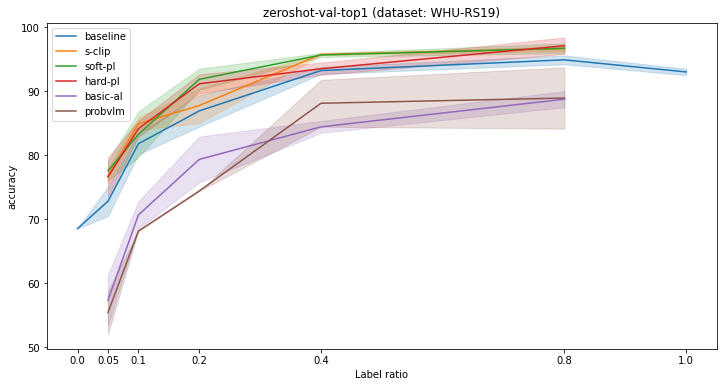

RSSCN7 zeroshot-val-top1
baseline zeroshot-val-top1 RSSCN7


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
4581  RSSCN7   False  zeroshot-val-top1  0.00       0.0  0.00005  None      0   
4587  RSSCN7   False  zeroshot-val-top1  0.05      25.0  0.00005  None     25   
4675  RSSCN7   False  zeroshot-val-top1  0.10      25.0  0.00005  None     25   
4763  RSSCN7   False  zeroshot-val-top1  0.20      25.0  0.00005  None     25   
4871  RSSCN7   False  zeroshot-val-top1  0.40      25.0  0.00005  None     25   
4979  RSSCN7   False  zeroshot-val-top1  0.80      25.0  0.00005  None     25   
5084  RSSCN7   False  zeroshot-val-top1  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
4581   base     NaN  64  55.000  0.000000     3  
4587   base     NaN  64  54.836  1.017561     5  
4675   base     NaN  64  63.492  3.774284     5  
4763   base     NaN  64  65.036  1.538597     5  
4871   base     NaN  64  64.236  2.246526     5  
4979   base     NaN  64  66.378  3.602835     5  
5084   base     NaN  64  66.872  1.670500     5

s-clip zeroshot-val-top1 RSSCN7


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
4639  RSSCN7   False  zeroshot-val-top1  0.05      25.0  0.00005  ot.image   
4727  RSSCN7   False  zeroshot-val-top1  0.10      25.0  0.00005  ot.image   
4815  RSSCN7   False  zeroshot-val-top1  0.20      25.0  0.00005  ot.image   
4923  RSSCN7   False  zeroshot-val-top1  0.40      25.0  0.00005  ot.image   
5029  RSSCN7   False  zeroshot-val-top1  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
4639     25   ours     NaN  128  57.146  3.059490     5  
4727     25   ours     NaN  128  59.454  0.143108     5  
4815     25   ours     NaN  128  66.004  3.049997     5  
4923     25   ours     NaN  128  59.682  2.173458     5  
5029     25   ours     NaN  128  66.902  0.465102     5

soft-pl zeroshot-val-top1 RSSCN7


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
4669  RSSCN7   False  zeroshot-val-top1  0.05      30.0  0.00005  soft.text   
4757  RSSCN7   False  zeroshot-val-top1  0.10      30.0  0.00005  soft.text   
4845  RSSCN7   False  zeroshot-val-top1  0.20      30.0  0.00005  soft.text   
4953  RSSCN7   False  zeroshot-val-top1  0.40      30.0  0.00005  soft.text   
5059  RSSCN7   False  zeroshot-val-top1  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
4669     30   ours     NaN  64  58.644  4.783020     5  
4757     30   ours     NaN  64  62.436  1.606200     5  
4845     30   ours     NaN  64  65.830  2.353657     5  
4953     30   ours     NaN  64  67.864  1.889704     5  
5059     30   ours     NaN  64  64.800  2.345666     5

hard-pl zeroshot-val-top1 RSSCN7


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
4614  RSSCN7   False  zeroshot-val-top1  0.05      25.0  0.00005  hard.text   
4702  RSSCN7   False  zeroshot-val-top1  0.10      25.0  0.00005  hard.text   
4790  RSSCN7   False  zeroshot-val-top1  0.20      25.0  0.00005  hard.text   
4898  RSSCN7   False  zeroshot-val-top1  0.40      25.0  0.00005  hard.text   
5004  RSSCN7   False  zeroshot-val-top1  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
4614     25   ours     NaN  64  56.786  3.571733     5  
4702     25   ours     NaN  64  58.944  1.496489     5  
4790     25   ours     NaN  64  64.956  3.422306     5  
4898     25   ours     NaN  64  66.790  1.980795     5  
5004     25   ours     NaN  64  64.002  0.720014     5

basic-al zeroshot-val-top1 RSSCN7


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
4582  RSSCN7   False  zeroshot-val-top1  0.05      10.0  0.00005  None     20   
4670  RSSCN7   False  zeroshot-val-top1  0.10      10.0  0.00005  None     20   
4758  RSSCN7   False  zeroshot-val-top1  0.20      10.0  0.00005  None     20   
4846  RSSCN7   False  zeroshot-val-top1  0.40      10.0  0.00005  None     20   
4954  RSSCN7   False  zeroshot-val-top1  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
4582   base     2.0  64  51.362  1.423032     5  
4670   base     5.0  64  62.174  2.590652     5  
4758   base    10.0  64  61.194  2.826974     5  
4846   base    20.0  64  57.972  1.330966     5  
4954   base    40.0  64  60.122  3.247995     5

probvlm zeroshot-val-top1 RSSCN7


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
5085  RSSCN7    True  zeroshot-val-top1  0.05      10.0  0.00005  None     25   
5086  RSSCN7    True  zeroshot-val-top1  0.10      10.0  0.00005  None     25   
5087  RSSCN7    True  zeroshot-val-top1  0.20      10.0  0.00005  None     25   
5088  RSSCN7    True  zeroshot-val-top1  0.40      10.0  0.00005  None     25   
5089  RSSCN7    True  zeroshot-val-top1  0.80      10.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
5085   base     2.0  32  44.728  2.186874     5  
5086   base     5.0  32  53.000  0.000000     5  
5087   base    10.0  32  58.640  0.000000     5  
5088   base    20.0  32  56.884  1.110892     5  
5089   base    40.0  32  59.535  2.269813     2

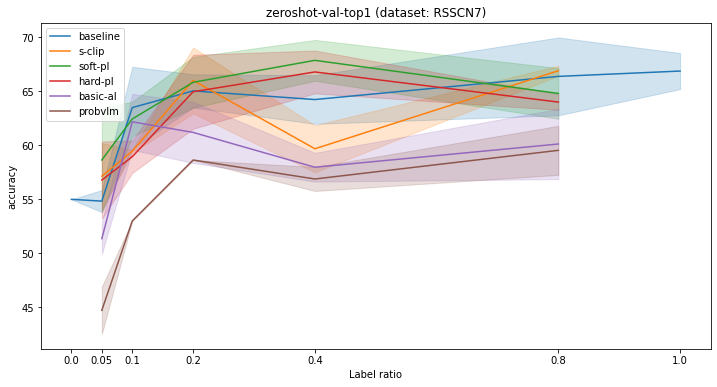

AID zeroshot-val-top1
baseline zeroshot-val-top1 AID


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                               
0       AID   False  zeroshot-val-top1  0.00       0.0  0.00005  None      0   
6       AID   False  zeroshot-val-top1  0.05      25.0  0.00005  None     25   
94      AID   False  zeroshot-val-top1  0.10      25.0  0.00005  None     25   
182     AID   False  zeroshot-val-top1  0.20      25.0  0.00005  None     25   
290     AID   False  zeroshot-val-top1  0.40      25.0  0.00005  None     25   
398     AID   False  zeroshot-val-top1  0.80      25.0  0.00005  None     25   
503     AID   False  zeroshot-val-top1  1.00      25.0  0.00005  None     25   

    method AL.iter  bs   value                  
                          mean       std count  
0     base     NaN  64  52.820  0.000000     2  
6     base     NaN  64  61.106  2.422329     5  
94    base     NaN  64  68.166  1.051038     5  
182   base     NaN  64  77.632  1.239706     5  
290   base     NaN  64  86.402  1.271739     5  
398   base     NaN  64  89.808  0.570500     5  
503   base     NaN  64  87.698  2.225774     5

s-clip zeroshot-val-top1 AID


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                            
58      AID   False  zeroshot-val-top1  0.05      25.0  0.00005  ot.image   
146     AID   False  zeroshot-val-top1  0.10      25.0  0.00005  ot.image   
234     AID   False  zeroshot-val-top1  0.20      25.0  0.00005  ot.image   
342     AID   False  zeroshot-val-top1  0.40      25.0  0.00005  ot.image   
448     AID   False  zeroshot-val-top1  0.80      25.0  0.00005  ot.image   

    epochs method AL.iter   bs   value                  
                                  mean       std count  
58      25   ours     NaN  128  60.780  1.260674     5  
146     25   ours     NaN  128  71.688  0.764735     5  
234     25   ours     NaN  128  81.980  0.201246     5  
342     25   ours     NaN  128  90.080  0.916788     5  
448     25   ours     NaN  128  91.262  0.152053     5

soft-pl zeroshot-val-top1 AID


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                             
88      AID   False  zeroshot-val-top1  0.05      30.0  0.00005  soft.text   
176     AID   False  zeroshot-val-top1  0.10      30.0  0.00005  soft.text   
264     AID   False  zeroshot-val-top1  0.20      30.0  0.00005  soft.text   
372     AID   False  zeroshot-val-top1  0.40      30.0  0.00005  soft.text   
478     AID   False  zeroshot-val-top1  0.80      30.0  0.00005  soft.text   

    epochs method AL.iter  bs   value                  
                                 mean       std count  
88      30   ours     NaN  64  61.662  1.410805     5  
176     30   ours     NaN  64  71.476  1.230114     5  
264     30   ours     NaN  64  83.206  0.878282     5  
372     30   ours     NaN  64  88.418  1.586591     5  
478     30   ours     NaN  64  92.858  0.868372     5

hard-pl zeroshot-val-top1 AID


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                             
33      AID   False  zeroshot-val-top1  0.05      25.0  0.00005  hard.text   
121     AID   False  zeroshot-val-top1  0.10      25.0  0.00005  hard.text   
209     AID   False  zeroshot-val-top1  0.20      25.0  0.00005  hard.text   
317     AID   False  zeroshot-val-top1  0.40      25.0  0.00005  hard.text   
423     AID   False  zeroshot-val-top1  0.80      25.0  0.00005  hard.text   

    epochs method AL.iter  bs   value                  
                                 mean       std count  
33      25   ours     NaN  64  62.148  1.000335     5  
121     25   ours     NaN  64  71.790  0.514296     5  
209     25   ours     NaN  64  81.180  0.213307     5  
317     25   ours     NaN  64  87.206  1.901534     5  
423     25   ours     NaN  64  90.238  0.787096     5

basic-al zeroshot-val-top1 AID


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                               
1       AID   False  zeroshot-val-top1  0.05      10.0  0.00005  None     20   
89      AID   False  zeroshot-val-top1  0.10      10.0  0.00005  None     20   
177     AID   False  zeroshot-val-top1  0.20      10.0  0.00005  None     20   
265     AID   False  zeroshot-val-top1  0.40      10.0  0.00005  None     20   
373     AID   False  zeroshot-val-top1  0.80      10.0  0.00005  None     20   

    method AL.iter  bs   value                  
                          mean       std count  
1     base     2.0  64  41.808  3.546022     5  
89    base     5.0  64  58.554  4.111032     5  
177   base    10.0  64  65.626  5.568454     5  
265   base    20.0  64  75.212  5.137638     5  
373   base    40.0  64  81.850  1.177603     5

probvlm zeroshot-val-top1 AID


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                               
504     AID    True  zeroshot-val-top1  0.05      10.0  0.00005  None     25   
505     AID    True  zeroshot-val-top1  0.10      10.0  0.00005  None     25   
506     AID    True  zeroshot-val-top1  0.20      10.0  0.00005  None     25   
507     AID    True  zeroshot-val-top1  0.40      10.0  0.00005  None     25   
508     AID    True  zeroshot-val-top1  0.80      10.0  0.00005  None     25   

    method AL.iter  bs   value                  
                          mean       std count  
504   base     2.0  32  40.574  2.294206     5  
505   base     5.0  32  57.000  0.000000     5  
506   base    10.0  32  66.170  0.000000     5  
507   base    20.0  32  77.952  4.788661     5  
508   base    40.0  32  85.485  2.750645     2

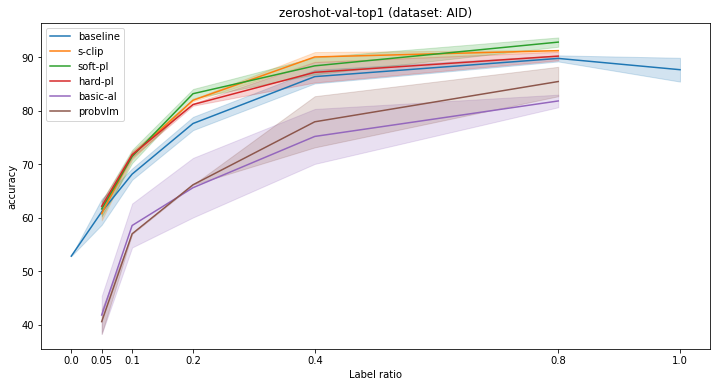

RESISC45 zeroshot-val-top1
baseline zeroshot-val-top1 RESISC45


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                           
509   RESISC45   False  zeroshot-val-top1  0.00       0.0  0.00005  None   
515   RESISC45   False  zeroshot-val-top1  0.05      25.0  0.00005  None   
603   RESISC45   False  zeroshot-val-top1  0.10      25.0  0.00005  None   
691   RESISC45   False  zeroshot-val-top1  0.20      25.0  0.00005  None   
799   RESISC45   False  zeroshot-val-top1  0.40      25.0  0.00005  None   
907   RESISC45   False  zeroshot-val-top1  0.80      25.0  0.00005  None   
1012  RESISC45   False  zeroshot-val-top1  1.00      25.0  0.00005  None   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
509       0   base     NaN  64  48.710  0.000000     2  
515      25   base     NaN  64  31.408  1.490493     5  
603      25   base     NaN  64  32.692  1.019348     5  
691      25   base     NaN  64  38.208  1.053931     5  
799      25   base     NaN  64  40.236  1.704503     5  
907      25   base     NaN  64  43.876  1.197969     5  
1012     25   base     NaN  64  45.844  0.564385     5

s-clip zeroshot-val-top1 RESISC45


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                              
567  RESISC45   False  zeroshot-val-top1  0.05      25.0  0.00005  ot.image   
655  RESISC45   False  zeroshot-val-top1  0.10      25.0  0.00005  ot.image   
743  RESISC45   False  zeroshot-val-top1  0.20      25.0  0.00005  ot.image   
851  RESISC45   False  zeroshot-val-top1  0.40      25.0  0.00005  ot.image   
957  RESISC45   False  zeroshot-val-top1  0.80      25.0  0.00005  ot.image   

    epochs method AL.iter   bs   value                  
                                  mean       std count  
567     25   ours     NaN  128  31.670  0.645794     5  
655     25   ours     NaN  128  35.382  0.643988     5  
743     25   ours     NaN  128  42.808  1.748605     5  
851     25   ours     NaN  128  46.538  0.040249     5  
957     25   ours     NaN  128  49.022  1.957682     5

soft-pl zeroshot-val-top1 RESISC45


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                               
597  RESISC45   False  zeroshot-val-top1  0.05      30.0  0.00005  soft.text   
685  RESISC45   False  zeroshot-val-top1  0.10      30.0  0.00005  soft.text   
773  RESISC45   False  zeroshot-val-top1  0.20      30.0  0.00005  soft.text   
881  RESISC45   False  zeroshot-val-top1  0.40      30.0  0.00005  soft.text   
987  RESISC45   False  zeroshot-val-top1  0.80      30.0  0.00005  soft.text   

    epochs method AL.iter  bs   value                  
                                 mean       std count  
597     30   ours     NaN  64  30.328  1.330233     5  
685     30   ours     NaN  64  36.942  2.449514     5  
773     30   ours     NaN  64  44.372  1.224978     5  
881     30   ours     NaN  64  45.820  1.336095     5  
987     30   ours     NaN  64  46.714  2.242338     5

hard-pl zeroshot-val-top1 RESISC45


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                               
542  RESISC45   False  zeroshot-val-top1  0.05      25.0  0.00005  hard.text   
630  RESISC45   False  zeroshot-val-top1  0.10      25.0  0.00005  hard.text   
718  RESISC45   False  zeroshot-val-top1  0.20      25.0  0.00005  hard.text   
826  RESISC45   False  zeroshot-val-top1  0.40      25.0  0.00005  hard.text   
932  RESISC45   False  zeroshot-val-top1  0.80      25.0  0.00005  hard.text   

    epochs method AL.iter  bs   value                  
                                 mean       std count  
542     25   ours     NaN  64  29.532  1.536219     5  
630     25   ours     NaN  64  35.312  0.492818     5  
718     25   ours     NaN  64  40.044  1.627108     5  
826     25   ours     NaN  64  44.900  1.230406     5  
932     25   ours     NaN  64  45.998  0.375659     5

basic-al zeroshot-val-top1 RESISC45


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
510  RESISC45   False  zeroshot-val-top1  0.05      10.0  0.00005  None   
598  RESISC45   False  zeroshot-val-top1  0.10      10.0  0.00005  None   
686  RESISC45   False  zeroshot-val-top1  0.20      10.0  0.00005  None   
774  RESISC45   False  zeroshot-val-top1  0.40      10.0  0.00005  None   
882  RESISC45   False  zeroshot-val-top1  0.80      10.0  0.00005  None   

    epochs method AL.iter  bs   value                  
                                 mean       std count  
510     20   base     2.0  64  22.062  2.054062     5  
598     20   base     5.0  64  28.878  0.493072     5  
686     20   base    10.0  64  32.034  3.995263     5  
774     20   base    20.0  64  36.426  2.322344     5  
882     20   base    40.0  64  39.226  0.432701     5

probvlm zeroshot-val-top1 RESISC45


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                           
1013  RESISC45    True  zeroshot-val-top1  0.05      10.0  0.00005  None   
1014  RESISC45    True  zeroshot-val-top1  0.10      10.0  0.00005  None   
1015  RESISC45    True  zeroshot-val-top1  0.20      10.0  0.00005  None   
1016  RESISC45    True  zeroshot-val-top1  0.40      10.0  0.00005  None   
1017  RESISC45    True  zeroshot-val-top1  0.80      10.0  0.00005  None   

     epochs method AL.iter  bs   value                      
                                  mean           std count  
1013     25   base     2.0  32  21.322  2.504396e-01     5  
1014     25   base     5.0  32  27.030  0.000000e+00     5  
1015     25   base    10.0  32  27.190  3.972055e-15     5  
1016     25   base    20.0  32  33.748  2.435061e+00     5  
1017     25   base    40.0  32  34.285  1.902117e+00     2

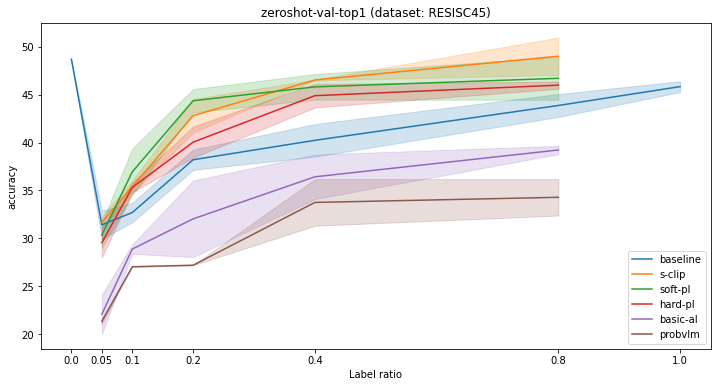

In [20]:
metric = 'zeroshot-val-top1'
datasets = ["RSICD-CLS", "UCM-CLS", "WHU-RS19", "RSSCN7", "AID", "RESISC45"]
for dataset in datasets:
    print(dataset, metric)
    plot_model_comparison(results_dict, metric, dataset)

baseline text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
3538   RSICD   False  text_to_image_R@5  0.00       0.0  0.00005  None      0   
3544   RSICD   False  text_to_image_R@5  0.05      25.0  0.00005  None     25   
3632   RSICD   False  text_to_image_R@5  0.10      25.0  0.00005  None     25   
3720   RSICD   False  text_to_image_R@5  0.20      25.0  0.00005  None     25   
3828   RSICD   False  text_to_image_R@5  0.40      25.0  0.00005  None     25   
3936   RSICD   False  text_to_image_R@5  0.80      25.0  0.00005  None     25   
4041   RSICD   False  text_to_image_R@5  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
3538   base     NaN  64  14.270  0.000000     2  
3544   base     NaN  64  13.122  0.420678     5  
3632   base     NaN  64  16.690  0.939920     5  
3720   base     NaN  64  20.806  1.018052     5  
3828   base     NaN  64  24.904  0.638968     5  
3936   base     NaN  64  29.532  0.979525     5  
4041   base     NaN  64  31.070  1.026913     5

s-clip text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
3596   RSICD   False  text_to_image_R@5  0.05      25.0  0.00005  ot.image   
3684   RSICD   False  text_to_image_R@5  0.10      25.0  0.00005  ot.image   
3772   RSICD   False  text_to_image_R@5  0.20      25.0  0.00005  ot.image   
3880   RSICD   False  text_to_image_R@5  0.40      25.0  0.00005  ot.image   
3986   RSICD   False  text_to_image_R@5  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
3596     25   ours     NaN  128  13.924  0.474847     5  
3684     25   ours     NaN  128  17.196  0.818401     5  
3772     25   ours     NaN  128  19.978  0.286217     5  
3880     25   ours     NaN  128  23.462  0.898899     5  
3986     25   ours     NaN  128  28.968  0.733430     5

soft-pl text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
3626   RSICD   False  text_to_image_R@5  0.05      30.0  0.00005  soft.text   
3714   RSICD   False  text_to_image_R@5  0.10      30.0  0.00005  soft.text   
3802   RSICD   False  text_to_image_R@5  0.20      30.0  0.00005  soft.text   
3910   RSICD   False  text_to_image_R@5  0.40      30.0  0.00005  soft.text   
4016   RSICD   False  text_to_image_R@5  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
3626     30   ours     NaN  64  14.638  0.614549     5  
3714     30   ours     NaN  64  18.152  0.697653     5  
3802     30   ours     NaN  64  22.234  1.206764     5  
3910     30   ours     NaN  64  25.712  0.497112     5  
4016     30   ours     NaN  64  30.062  1.053551     5

hard-pl text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
3571   RSICD   False  text_to_image_R@5  0.05      25.0  0.00005  hard.text   
3659   RSICD   False  text_to_image_R@5  0.10      25.0  0.00005  hard.text   
3747   RSICD   False  text_to_image_R@5  0.20      25.0  0.00005  hard.text   
3855   RSICD   False  text_to_image_R@5  0.40      25.0  0.00005  hard.text   
3961   RSICD   False  text_to_image_R@5  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
3571     25   ours     NaN  64  13.630  0.606795     5  
3659     25   ours     NaN  64  17.988  1.053812     5  
3747     25   ours     NaN  64  20.258  0.612021     5  
3855     25   ours     NaN  64  25.616  0.849723     5  
3961     25   ours     NaN  64  30.248  0.532184     5

basic-al text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
3539   RSICD   False  text_to_image_R@5  0.05      10.0  0.00005  None     20   
3627   RSICD   False  text_to_image_R@5  0.10      10.0  0.00005  None     20   
3715   RSICD   False  text_to_image_R@5  0.20      10.0  0.00005  None     20   
3803   RSICD   False  text_to_image_R@5  0.40      10.0  0.00005  None     20   
3911   RSICD   False  text_to_image_R@5  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
3539   base     2.0  64   8.324  1.836608     5  
3627   base     5.0  64  12.422  0.075299     5  
3715   base    10.0  64  15.830  1.833548     5  
3803   base    20.0  64  20.806  1.456942     5  
3911   base    40.0  64  24.210  0.301247     5

probvlm text_to_image_R@5 RSICD


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
4067   RSICD    True  text_to_image_R@5  0.05      10.0  0.00005  None     25   
4068   RSICD    True  text_to_image_R@5  0.10      10.0  0.00005  None     25   
4069   RSICD    True  text_to_image_R@5  0.20      10.0  0.00005  None     25   
4070   RSICD    True  text_to_image_R@5  0.40      10.0  0.00005  None     25   
4071   RSICD    True  text_to_image_R@5  0.80      10.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
4067   base     2.0  32   7.760  0.245967     5  
4068   base     5.0  32  12.630  0.000000     5  
4069   base    10.0  32  17.020  0.000000     5  
4070   base    20.0  32  21.082  0.339588     5  
4071   base    40.0  32  24.335  1.294005     2

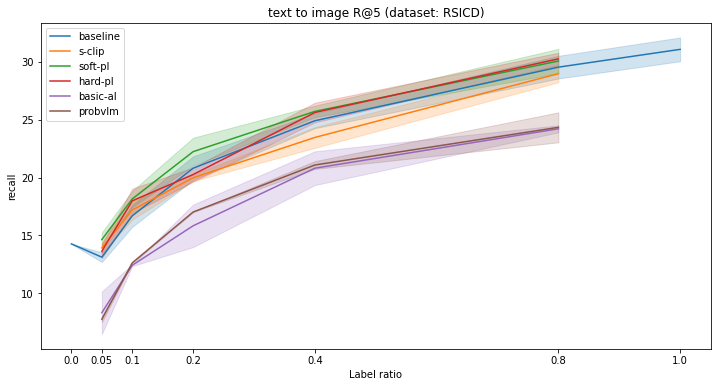

baseline text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
10664     UCM   False  text_to_image_R@5  0.00       0.0  0.00005  None   
10670     UCM   False  text_to_image_R@5  0.05      25.0  0.00005  None   
10758     UCM   False  text_to_image_R@5  0.10      25.0  0.00005  None   
10846     UCM   False  text_to_image_R@5  0.20      25.0  0.00005  None   
10954     UCM   False  text_to_image_R@5  0.40      25.0  0.00005  None   
11062     UCM   False  text_to_image_R@5  0.80      25.0  0.00005  None   
11167     UCM   False  text_to_image_R@5  1.00      25.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10664      0   base     NaN  64  31.430  0.000000     2  
10670     25   base     NaN  64  35.142  3.341118     5  
10758     25   base     NaN  64  38.096  1.814657     5  
10846     25   base     NaN  64  48.666  1.033697     5  
10954     25   base     NaN  64  50.666  1.735578     5  
11062     25   base     NaN  64  55.334  1.824179     5  
11167     25   base     NaN  64  59.714  2.558062     5

s-clip text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                              
10722     UCM   False  text_to_image_R@5  0.05      25.0  0.00005  ot.image   
10810     UCM   False  text_to_image_R@5  0.10      25.0  0.00005  ot.image   
10898     UCM   False  text_to_image_R@5  0.20      25.0  0.00005  ot.image   
11006     UCM   False  text_to_image_R@5  0.40      25.0  0.00005  ot.image   
11112     UCM   False  text_to_image_R@5  0.80      25.0  0.00005  ot.image   

      epochs method AL.iter   bs   value                  
                                    mean       std count  
10722     25   ours     NaN  128  36.096  1.829393     5  
10810     25   ours     NaN  128  43.140  0.424853     5  
10898     25   ours     NaN  128  52.950  0.849706     5  
11006     25   ours     NaN  128  51.900  0.000000     5  
11112     25   ours     NaN  128  58.854  1.489221     5

soft-pl text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                               
10752     UCM   False  text_to_image_R@5  0.05      30.0  0.00005  soft.text   
10840     UCM   False  text_to_image_R@5  0.10      30.0  0.00005  soft.text   
10928     UCM   False  text_to_image_R@5  0.20      30.0  0.00005  soft.text   
11036     UCM   False  text_to_image_R@5  0.40      30.0  0.00005  soft.text   
11142     UCM   False  text_to_image_R@5  0.80      30.0  0.00005  soft.text   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10752     30   ours     NaN  64  38.192  3.292107     5  
10840     30   ours     NaN  64  42.476  1.362289     5  
10928     30   ours     NaN  64  46.474  0.926974     5  
11036     30   ours     NaN  64  52.188  1.192841     5  
11142     30   ours     NaN  64  57.618  1.431667     5

hard-pl text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                               
10697     UCM   False  text_to_image_R@5  0.05      25.0  0.00005  hard.text   
10785     UCM   False  text_to_image_R@5  0.10      25.0  0.00005  hard.text   
10873     UCM   False  text_to_image_R@5  0.20      25.0  0.00005  hard.text   
10981     UCM   False  text_to_image_R@5  0.40      25.0  0.00005  hard.text   
11087     UCM   False  text_to_image_R@5  0.80      25.0  0.00005  hard.text   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10697     25   ours     NaN  64  35.430  3.755210     5  
10785     25   ours     NaN  64  43.906  3.390403     5  
10873     25   ours     NaN  64  48.476  3.202246     5  
10981     25   ours     NaN  64  53.998  3.096784     5  
11087     25   ours     NaN  64  59.808  2.553590     5

basic-al text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
10665     UCM   False  text_to_image_R@5  0.05      10.0  0.00005  None   
10753     UCM   False  text_to_image_R@5  0.10      10.0  0.00005  None   
10841     UCM   False  text_to_image_R@5  0.20      10.0  0.00005  None   
10929     UCM   False  text_to_image_R@5  0.40      10.0  0.00005  None   
11037     UCM   False  text_to_image_R@5  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
10665     20   base     2.0  64  33.428  1.915690     5  
10753     20   base     5.0  64  39.046  1.064368     5  
10841     20   base    10.0  64  42.856  1.344388     5  
10929     20   base    20.0  64  48.666  3.127496     5  
11037     20   base    40.0  64  52.858  1.303580     5

probvlm text_to_image_R@5 UCM


dataset ProbVLM             metric ratio AL.epochs       lr    PL  \
                                                                          
11193     UCM    True  text_to_image_R@5  0.05      10.0  0.00005  None   
11194     UCM    True  text_to_image_R@5  0.10      10.0  0.00005  None   
11195     UCM    True  text_to_image_R@5  0.20      10.0  0.00005  None   
11196     UCM    True  text_to_image_R@5  0.40      10.0  0.00005  None   
11197     UCM    True  text_to_image_R@5  0.80      10.0  0.00005  None   

      epochs method AL.iter  bs   value                  
                                   mean       std count  
11193     25   base     2.0  32  29.242  2.768252     5  
11194     25   base     5.0  32  36.190  0.000000     5  
11195     25   base    10.0  32  42.380  0.000000     5  
11196     25   base    20.0  32  45.528  2.768252     5  
11197     25   base    40.0  32  45.475  0.332340     2

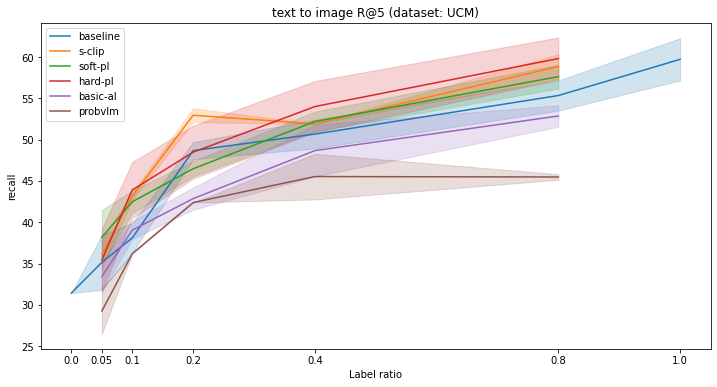

baseline text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
7610  Sydney   False  text_to_image_R@5  0.00       0.0  0.00005  None      0   
7616  Sydney   False  text_to_image_R@5  0.05      25.0  0.00005  None     25   
7704  Sydney   False  text_to_image_R@5  0.10      25.0  0.00005  None     25   
7792  Sydney   False  text_to_image_R@5  0.20      25.0  0.00005  None     25   
7900  Sydney   False  text_to_image_R@5  0.40      25.0  0.00005  None     25   
8008  Sydney   False  text_to_image_R@5  0.80      25.0  0.00005  None     25   
8113  Sydney   False  text_to_image_R@5  1.00      25.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
7610   base     NaN  64  10.660  0.000000     2  
7616   base     NaN  64  10.746  0.677370     5  
7704   base     NaN  64  14.406  1.293940     5  
7792   base     NaN  64  18.350  2.141775     5  
7900   base     NaN  64  27.044  1.087764     5  
8008   base     NaN  64  36.578  1.041091     5  
8113   base     NaN  64  37.666  0.438668     5

s-clip text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr        PL  \
                                                                             
7668  Sydney   False  text_to_image_R@5  0.05      25.0  0.00005  ot.image   
7756  Sydney   False  text_to_image_R@5  0.10      25.0  0.00005  ot.image   
7844  Sydney   False  text_to_image_R@5  0.20      25.0  0.00005  ot.image   
7952  Sydney   False  text_to_image_R@5  0.40      25.0  0.00005  ot.image   
8058  Sydney   False  text_to_image_R@5  0.80      25.0  0.00005  ot.image   

     epochs method AL.iter   bs   value                  
                                   mean       std count  
7668     25   ours     NaN  128   9.742  1.077785     5  
7756     25   ours     NaN  128  14.568  0.720014     5  
7844     25   ours     NaN  128  17.140  0.357771     5  
7952     25   ours     NaN  128  22.014  1.529470     5  
8058     25   ours     NaN  128  31.710  0.178885     5

soft-pl text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
7698  Sydney   False  text_to_image_R@5  0.05      30.0  0.00005  soft.text   
7786  Sydney   False  text_to_image_R@5  0.10      30.0  0.00005  soft.text   
7874  Sydney   False  text_to_image_R@5  0.20      30.0  0.00005  soft.text   
7982  Sydney   False  text_to_image_R@5  0.40      30.0  0.00005  soft.text   
8088  Sydney   False  text_to_image_R@5  0.80      30.0  0.00005  soft.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
7698     30   ours     NaN  64  11.146  2.197494     5  
7786     30   ours     NaN  64  12.714  1.453850     5  
7874     30   ours     NaN  64  17.382  0.719458     5  
7982     30   ours     NaN  64  20.806  1.218536     5  
8088     30   ours     NaN  64  27.848  0.442063     5

hard-pl text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr         PL  \
                                                                              
7643  Sydney   False  text_to_image_R@5  0.05      25.0  0.00005  hard.text   
7731  Sydney   False  text_to_image_R@5  0.10      25.0  0.00005  hard.text   
7819  Sydney   False  text_to_image_R@5  0.20      25.0  0.00005  hard.text   
7927  Sydney   False  text_to_image_R@5  0.40      25.0  0.00005  hard.text   
8033  Sydney   False  text_to_image_R@5  0.80      25.0  0.00005  hard.text   

     epochs method AL.iter  bs   value                  
                                  mean       std count  
7643     25   ours     NaN  64   9.656  0.752350     5  
7731     25   ours     NaN  64  12.876  0.493994     5  
7819     25   ours     NaN  64  16.016  0.848664     5  
7927     25   ours     NaN  64  21.328  1.865508     5  
8033     25   ours     NaN  64  26.200  0.089443     5

basic-al text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
7611  Sydney   False  text_to_image_R@5  0.05      10.0  0.00005  None     20   
7699  Sydney   False  text_to_image_R@5  0.10      10.0  0.00005  None     20   
7787  Sydney   False  text_to_image_R@5  0.20      10.0  0.00005  None     20   
7875  Sydney   False  text_to_image_R@5  0.40      10.0  0.00005  None     20   
7983  Sydney   False  text_to_image_R@5  0.80      10.0  0.00005  None     20   

     method AL.iter  bs   value                  
                           mean       std count  
7611   base     2.0  64   8.250  0.648074     5  
7699   base     5.0  64  10.464  1.797799     5  
7787   base    10.0  64  16.096  4.025001     5  
7875   base    20.0  64  21.324  3.855967     5  
7983   base    40.0  64  33.122  1.763667     5

probvlm text_to_image_R@5 Sydney


dataset ProbVLM             metric ratio AL.epochs       lr    PL epochs  \
                                                                                
8139  Sydney    True  text_to_image_R@5  0.05      10.0  0.00005  None     25   
8140  Sydney    True  text_to_image_R@5  0.10      10.0  0.00005  None     25   
8141  Sydney    True  text_to_image_R@5  0.20      10.0  0.00005  None     25   
8142  Sydney    True  text_to_image_R@5  0.40      10.0  0.00005  None     25   
8143  Sydney    True  text_to_image_R@5  0.80      10.0  0.00005  None     25   

     method AL.iter  bs   value                  
                           mean       std count  
8139   base     2.0  32   8.810  0.089443     5  
8140   base     5.0  32  13.480  0.000000     5  
8141   base    10.0  32  12.680  0.000000     5  
8142   base    20.0  32  15.978  0.718624     5  
8143   base    40.0  32  18.815  1.845549     2

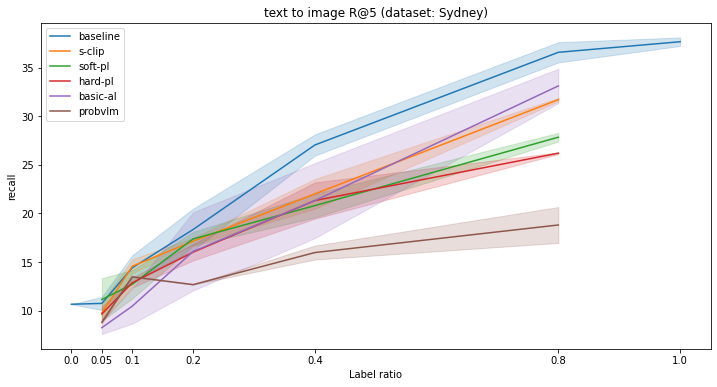

In [21]:
metric = 'text_to_image_R@5'
datasets = ['RSICD', 'UCM', 'Sydney']
for dataset in datasets:
    plot_model_comparison(results_dict, metric, dataset)